# Dataset

In [ ]:
import pandas as pd
import requests

def load_default_data():
    url = "https://raw.githubusercontent.com/vousmeevoyez/public-files/refs/heads/main/tabel_sensor4_generated.csv"
    response = requests.get(url)
    response.raise_for_status()
    from io import StringIO
    return pd.read_csv(StringIO(response.text))


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

global df
df = load_default_data()

# Ensure kelembaban1-4 columns are available
kelembaban_cols = ["kelembaban1", "kelembaban2", "kelembaban3", "kelembaban4"]
for col in kelembaban_cols:
    if col not in df.columns:
        raise ValueError(f"Column {col} not found in dataset. Required columns: {kelembaban_cols}")

# Create kelembaban_tanah_persen from average of kelembaban1-4 for backward compatibility
if "kelembaban_tanah_persen" not in df.columns:
    df["kelembaban_tanah_persen"] = df[kelembaban_cols].mean(axis=1)
    df["kelembaban_tanah_persen"] = None  # fallback if missing entirely

# Optional cleanup (drop the old kelembaban1–4 columns if you don't need them)
# df = df.drop(columns=["kelembaban1","kelembaban2","kelembaban3","kelembaban4"], errors='ignore')


# Inject fault to data

In [ ]:
import numpy as np
import functools

base = 'kelembaban_tanah_persen'


# --- Fault simulators (subtler, different seed per call) ---
def simulate_drift_fault(x, intensity=0.02, seed=None):
    rng=np.random.default_rng(seed)
    # Standar: i(t) = i(t-1) + α (akumulatif)
    # Implementasi: np.cumsum([α] * len(x)) atau np.arange(len(x)) * α
    # α adalah increment konstan per timestep
    alpha = intensity  # Increment konstan per timestep
    # i(0)=0, i(1)=α, i(2)=2α, ..., i(t)=t*α
    drift = np.arange(len(x)) * alpha  # Akumulatif mulai dari 0
    y=x+drift; m=np.abs(drift)>1e-6; return y,m

def simulate_spike_fault(x, intensity=0.08, p=0.015, seed=None):
    rng=np.random.default_rng(seed)
    # Standar: Intermittent dengan periode konstan τ
    # Menggunakan periodik (t % τ == 0) bukan random
    # p digunakan untuk menentukan periode: τ = 1/p (dibulatkan)
    tau = max(1, int(1.0 / p)) if p > 0 else len(x)
    spikes = (np.arange(len(x)) % tau == 0).astype(float) * (intensity * np.nanstd(x))
    y=x+spikes; m=spikes!=0; return y,m

def simulate_bias_fault(x, bias=0.08, seed=None):
    y=x+bias; m=np.ones(len(x),bool); return y,m

def simulate_hardware_fault(x, stuck_prob=0.08, loss_prob=0.05, seed=None):
    rng=np.random.default_rng(seed)
    idx=rng.integers(len(x),size=len(x))
    m1=rng.random(len(x))<stuck_prob
    y=x.copy(); y[m1]=x[idx][m1]
    m2=rng.random(len(x))<loss_prob
    y[m2]=np.nan
    return y,(m1|m2)

def simulate_multiple_faults(x, faults, seed=None):
    y=x.copy(); m=np.zeros(len(x),bool)
    for f,kw in faults:
        y,mi=f(y,**kw,seed=seed); m|=mi
    return y,m



In [ ]:
def plot_with_mask(y_fault, mask, title, df=df, base=base, w=None, i0=0):
    if w is None: w = len(df)
    i1 = min(len(df), len(y_fault), len(mask), i0 + w)
    x = np.arange(i0, i1)
    plt.figure(figsize=(12,4))
    plt.plot(x, df[base].values[i0:i1], label="Original")
    plt.plot(x, y_fault[i0:i1], label=title, linestyle="--")
    idx = np.where(mask[i0:i1])[0]
    if len(idx): plt.scatter(x[idx], y_fault[i0:i1][idx], s=18, marker='o', label="fault points")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def describe(name, y, m, df=df, base=base, w=None):
    if w is None: w = len(y)
    ref = df[base].to_numpy()
    d = y - ref
    print(f"{name}: mask_pos={m.sum()} | in first {w}: {m[:w].sum()} | "
          f"delta_mean={np.nanmean(d):.4f} delta_std={np.nanstd(d):.4f} delta_max={np.nanmax(d):.4f}")

#@ **Skenario 1**

Chosen random fault type: spike
spike: mask_pos=4341 | in first 60763: 4341 | delta_mean=0.0386 delta_std=0.1392 delta_max=0.5403
overall label rate: 0.07144150222997547


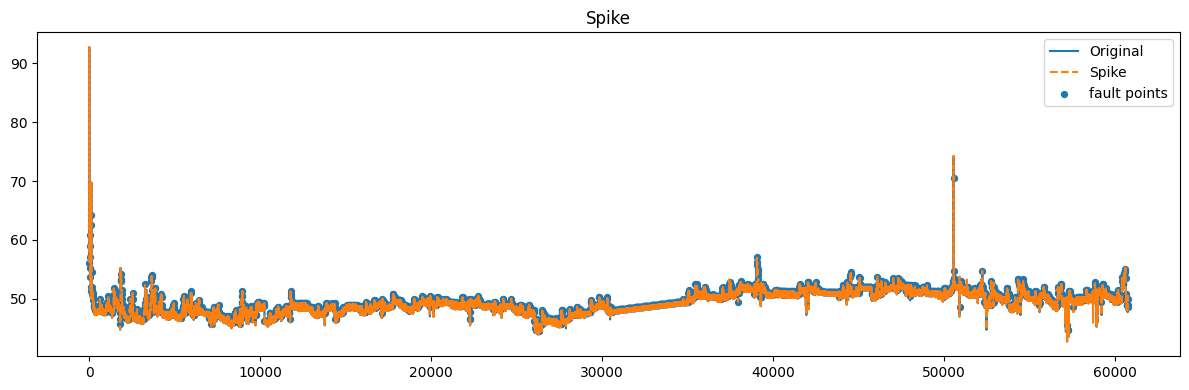

In [ ]:
import matplotlib.pyplot as plt



df_scenario_1 = df.copy()

# Candidate single-fault generators (return y, mask)
fault_choices = [
    ("drift",    simulate_drift_fault,    {"intensity": 0.15}),
    ("spike",    simulate_spike_fault,    {"intensity": 0.3, "p": 0.07}),
    ("bias",     simulate_bias_fault,     {"bias": 0.35}),
    ("hardware", simulate_hardware_fault, {"stuck_prob": 0.2, "loss_prob": 0.1}),
]

fault_name, fault_fn, fault_kwargs = fault_choices[np.random.randint(len(fault_choices))]
y_fault, m_fault = fault_fn(df[base].to_numpy(), **fault_kwargs)
    if m_fault.sum() == 0:
    # fallback to a fault that guarantees positives
    y_fault, m_fault = simulate_spike_fault(
        df[base].to_numpy(), intensity=0.5, p=0.2, seed=123
    )

# Add fault column + label
col_fault = f"{base}_{fault_name}"
df_scenario_1[col_fault] = y_fault
df_scenario_1['label_fault'] = m_fault.astype(int)

print(f"Chosen random fault type: {fault_name}")
describe(fault_name, y_fault, m_fault, df_scenario_1, base)
print("overall label rate:", df_scenario_1['label_fault'].mean())

# Plot in your preferred style
if fault_name == "hardware":
    plot_with_mask(np.nan_to_num(y_fault, nan=np.nanmedian(df[base])), m_fault, "Hardware (NaNs/stuck)")
else:
    plot_with_mask(y_fault, m_fault, fault_name.capitalize())

# Skenario 2

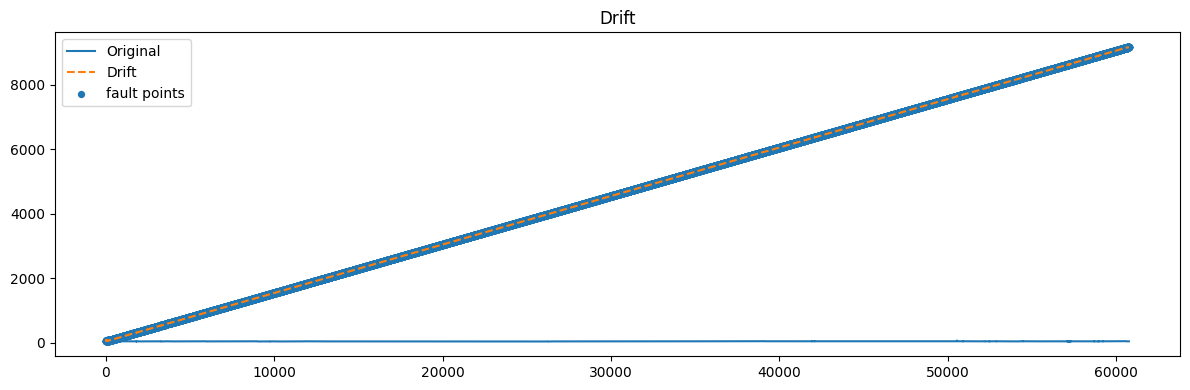

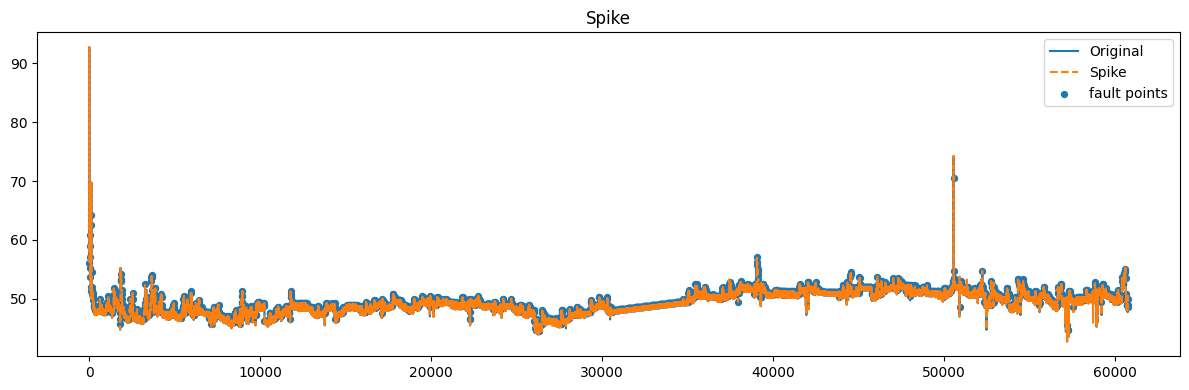

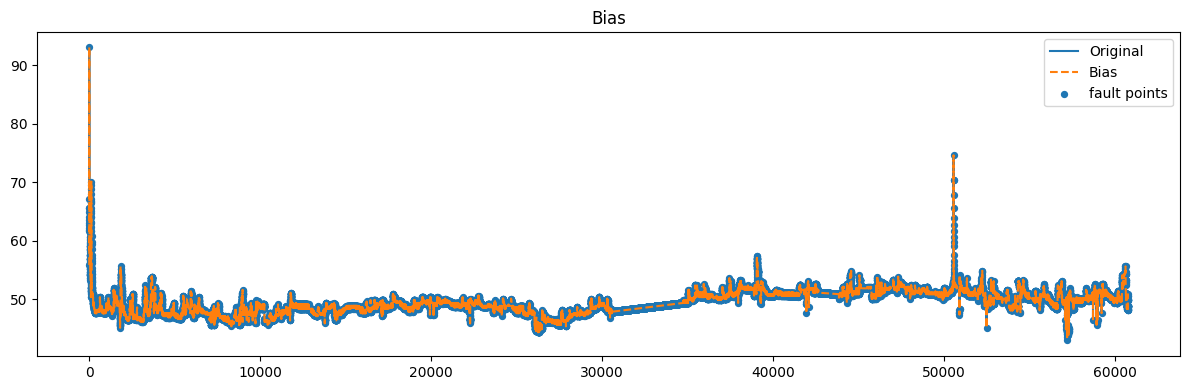

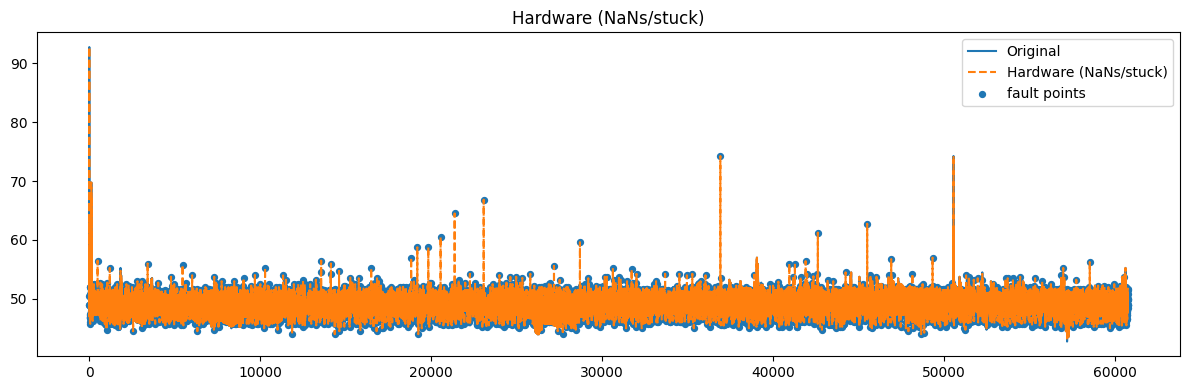

In [ ]:
# Skenario 2 (Hardened: avoid all-zero or all-one labels)

df_scenario_2 = df.copy()

# Rebuild faults with masks
y_drift, m_drift = simulate_drift_fault(df[base].to_numpy(), intensity=0.15)
y_spike, m_spike = simulate_spike_fault(df[base].to_numpy(), intensity=0.3, p=0.07)
y_bias,  m_bias  = simulate_bias_fault(df[base].to_numpy(), bias=0.35)   # note: returns all-True mask
y_hw,    m_hw    = simulate_hardware_fault(df[base].to_numpy(), stuck_prob=0.2, loss_prob=0.1)

df_scenario_2[base+'_drift']    = y_drift
df_scenario_2[base+'_spike']    = y_spike
df_scenario_2[base+'_bias']     = y_bias
df_scenario_2[base+'_hardware'] = y_hw
df_scenario_2['label_fault']    = (m_drift | m_spike | m_bias | m_hw).astype(int)

# --- Guard 1: 
if no positives, inject stronger spikes
if df_scenario_2['label_fault'].sum() == 0:
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_2[base].to_numpy(), intensity=0.5, p=0.2, seed=456
    )
    df_scenario_2[base+'_spike_strong'] = y_spike_strong
    df_scenario_2['label_fault'] = (df_scenario_2['label_fault'].values | m_spike_strong).astype(int)

# --- Guard 2: 
if still single-class (all-zeros or all-ones), rebuild from deviation
if df_scenario_2['label_fault'].nunique() < 2:
    base_vals = df_scenario_2[base].to_numpy()
    deltas = []
    for c in [base+'_drift', base+'_spike', base+'_bias', base+'_hardware']:
        if c in df_scenario_2:
            deltas.append(np.abs(df_scenario_2[c].to_numpy() - base_vals))
    if deltas:
        D = np.nanmax(np.stack(deltas, axis=1), axis=1)
        thr = np.nanpercentile(D, 80)  # top-20% by deviation -> positives
        df_scenario_2['label_fault'] = (D > thr).astype(int)

# --- Guard 3: last-resort tiny flips to ensure both classes
if df_scenario_2['label_fault'].nunique() < 2:
    rng = np.random.default_rng(4242)
    n = len(df_scenario_2)
    k = max(1, n // 200)  # ~0.5%
    if int(df_scenario_2['label_fault'].iloc[0]) == 1:
        idx = rng.choice(n, size=k, replace=False); df_scenario_2.loc[idx, 'label_fault'] = 0
    else:
        idx = rng.choice(n, size=k, replace=False); df_scenario_2.loc[idx, 'label_fault'] = 1

# Plots
plot_with_mask(y_drift, m_drift, "Drift")
plot_with_mask(y_spike, m_spike, "Spike")
plot_with_mask(y_bias,  m_bias,  "Bias")
plot_with_mask(np.nan_to_num(y_hw, nan=np.nanmedian(df[base])), m_hw, "Hardware (NaNs/stuck)")


# Skenario 3

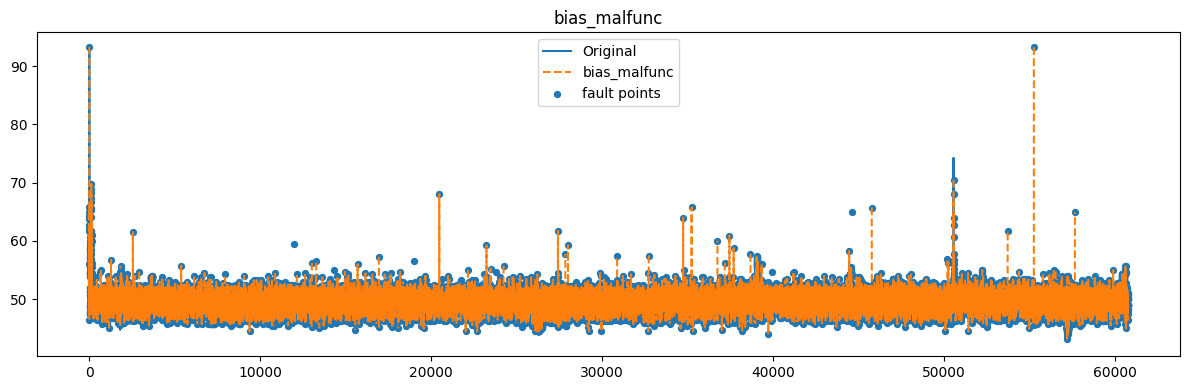

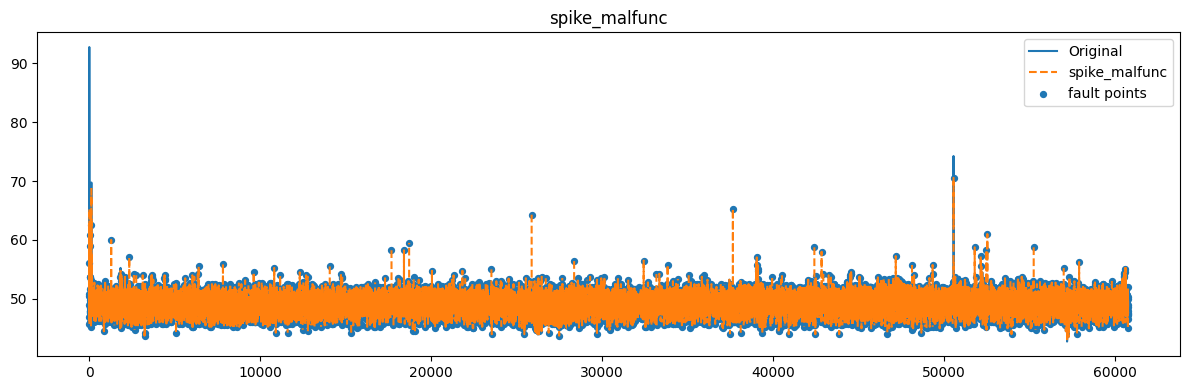

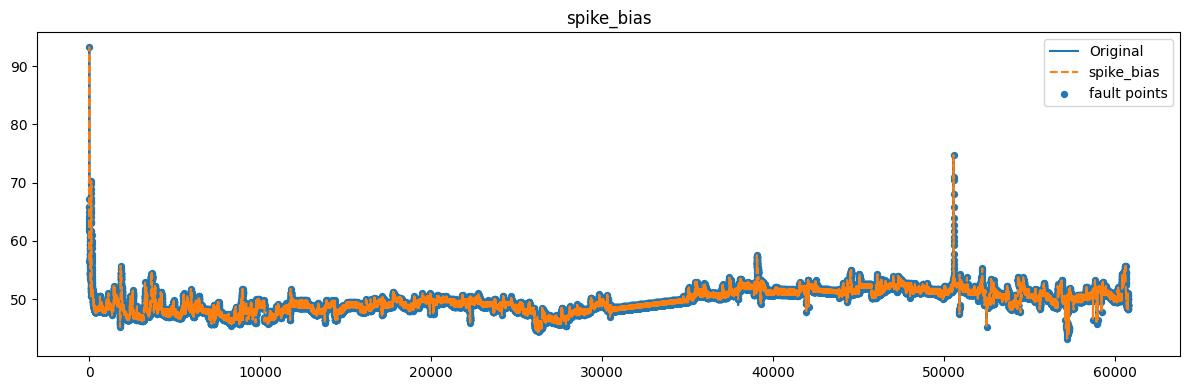

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


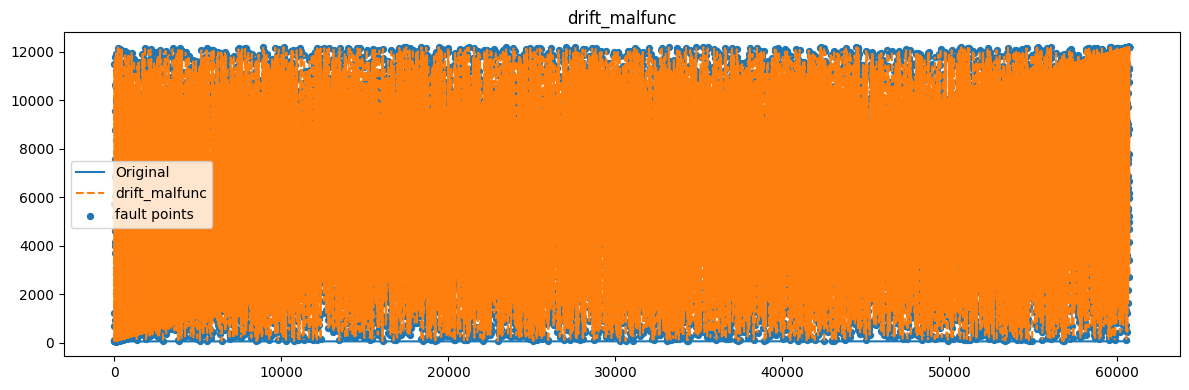

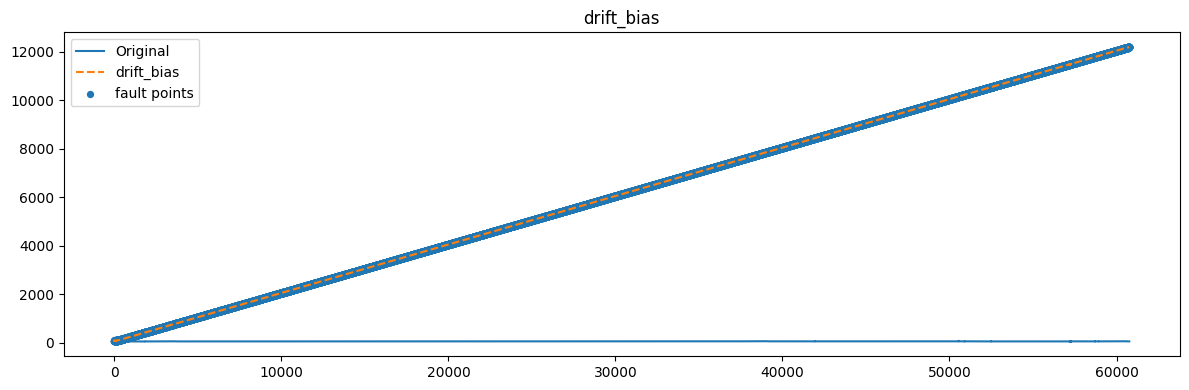

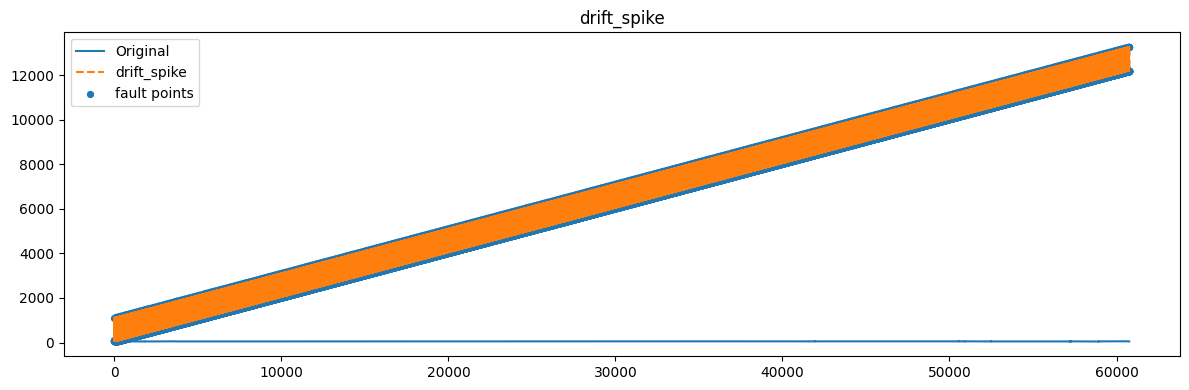

In [ ]:
# Skenario 3 (Hardened: never all-zero masks)

df_scenario_3 = df.copy()

# 1) Bias + Malfunc
y_bias_mal,  m_bias_mal  = simulate_multiple_faults(
    df_scenario_3[base].to_numpy(),
    [(simulate_bias_fault, {"bias": 0.5}),
     (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2})]
)
df_scenario_3[base+'_bias_malfunc']  = y_bias_mal
df_scenario_3['label_bias_malfunc']  = m_bias_mal.astype(int)

# 2) Spike + Malfunc
y_spike_mal, m_spike_mal = simulate_multiple_faults(
    df_scenario_3[base].to_numpy(),
    [(simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
     (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2})]
)
df_scenario_3[base+'_spike_malfunc'] = y_spike_mal
df_scenario_3['label_spike_malfunc'] = m_spike_mal.astype(int)

# 3) Spike + Bias
y_spike_bias, m_spike_bias = simulate_multiple_faults(
    df_scenario_3[base].to_numpy(),
    [(simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
     (simulate_bias_fault,  {"bias": 0.5})]
)
df_scenario_3[base+'_spike_bias']    = y_spike_bias
df_scenario_3['label_spike_bias']    = m_spike_bias.astype(int)

# 4) Drift + Malfunc
y_drift_mal, m_drift_mal = simulate_multiple_faults(
    df_scenario_3[base].to_numpy(),
    [(simulate_drift_fault, {"intensity": 0.2}),
     (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2})]
)
df_scenario_3[base+'_drift_malfunc'] = y_drift_mal
df_scenario_3['label_drift_malfunc'] = m_drift_mal.astype(int)

# 5) Drift + Bias
y_drift_bias, m_drift_bias = simulate_multiple_faults(
    df_scenario_3[base].to_numpy(),
    [(simulate_drift_fault, {"intensity": 0.2}),
     (simulate_bias_fault,  {"bias": 0.5})]
)
df_scenario_3[base+'_drift_bias']    = y_drift_bias
df_scenario_3['label_drift_bias']    = m_drift_bias.astype(int)

# 6) Drift + Spike
y_drift_spike, m_drift_spike = simulate_multiple_faults(
    df_scenario_3[base].to_numpy(),
    [(simulate_drift_fault, {"intensity": 0.2}),
     (simulate_spike_fault, {"intensity": 0.3, "p": 0.07})]
)
df_scenario_3[base+'_drift_spike']   = y_drift_spike
df_scenario_3['label_drift_spike']   = m_drift_spike.astype(int)

# Unified ground truth 
for Scenario 3
df_scenario_3['label_fault'] = np.logical_or.reduce(
    [m_bias_mal, m_spike_mal, m_spike_bias, m_drift_mal, m_drift_bias, m_drift_spike]
).astype(int)

# --- Hardened guard: ensure at least some positives
if df_scenario_3['label_fault'].sum() == 0:
    # Inject a stronger sparse spike pattern and OR it in
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_3[base].to_numpy(), intensity=0.5, p=0.2, seed=456
    )
    df_scenario_3[base+'_spike_strong'] = y_spike_strong
    df_scenario_3['label_fault'] = (df_scenario_3['label_fault'].values | m_spike_strong).astype(int)

# (optional) quick sanity print
#print("Scenario 3 positive rate:", df_scenario_3['label_fault'].mean())

# Plots
plot_with_mask(y_bias_mal, m_bias_mal, "bias_malfunc")
plot_with_mask(y_spike_mal, m_spike_mal, "spike_malfunc")
plot_with_mask(y_spike_bias, m_spike_bias, "spike_bias")
plot_with_mask(y_drift_mal, m_drift_mal, "drift_malfunc")
plot_with_mask(y_drift_bias, m_drift_bias, "drift_bias")
plot_with_mask(y_drift_spike, m_drift_spike, "drift_spike")


# Skenario 4

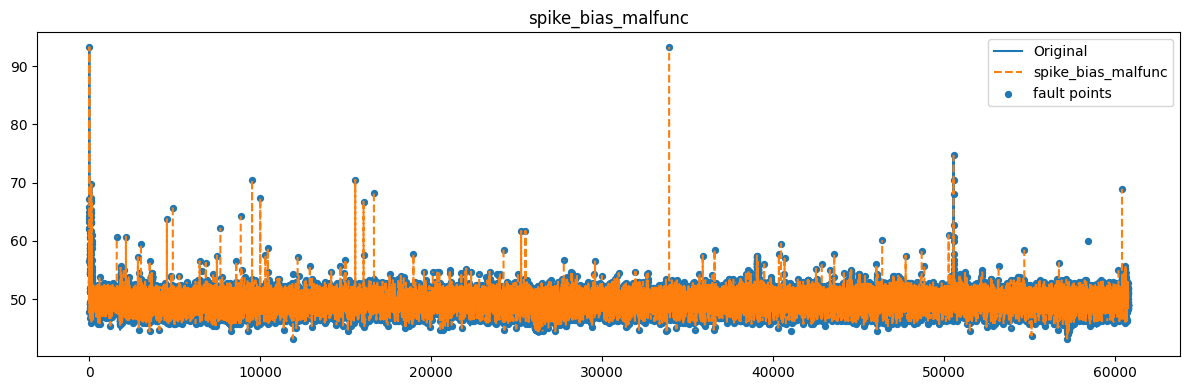

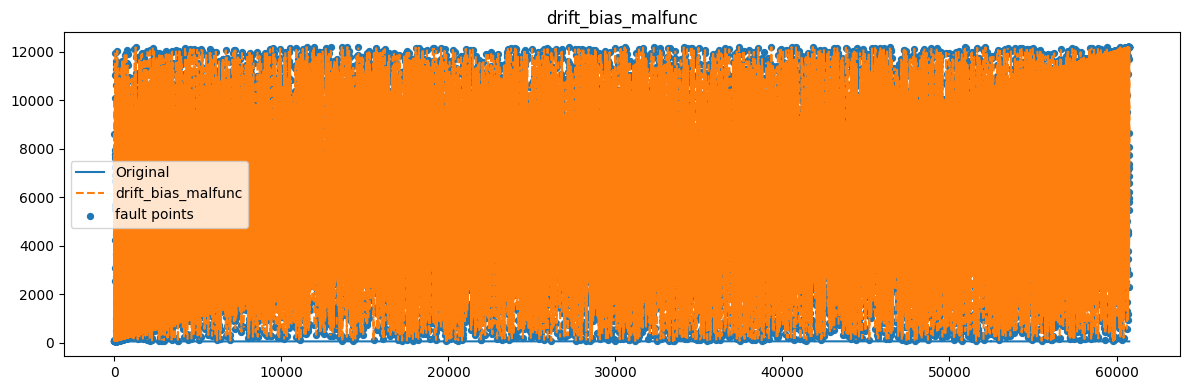

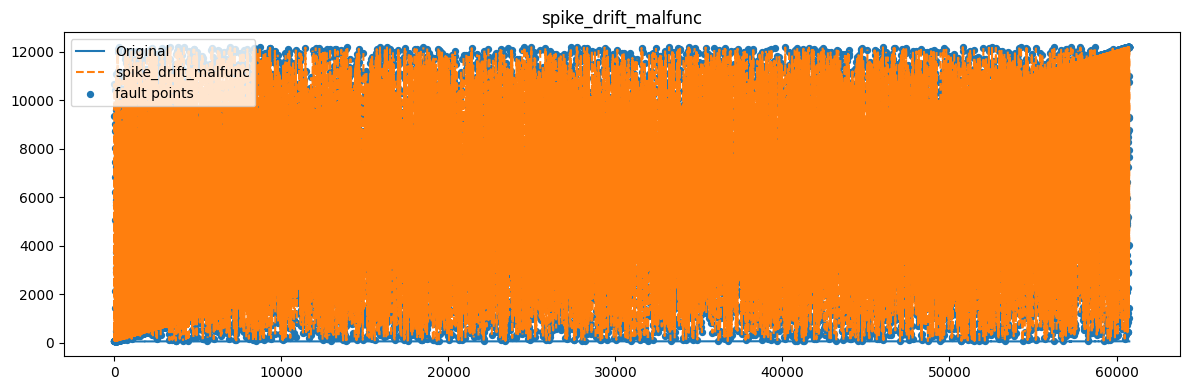

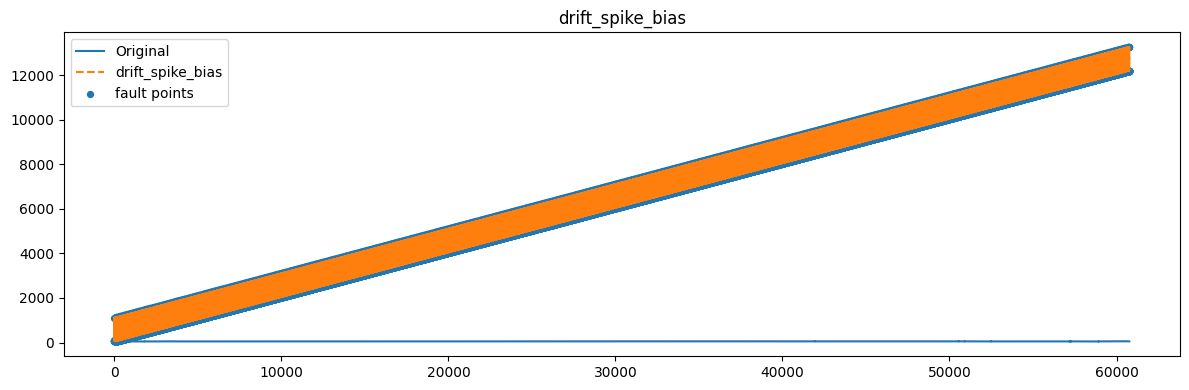

In [ ]:
# Skenario 4 (Hardened: never all-zero masks)

df_scenario_4 = df.copy()

# 1) Spike + Bias + Malfunc
y_spike_bias_mal, m_spike_bias_mal = simulate_multiple_faults(
    df_scenario_4[base].to_numpy(),
    [
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_bias_fault,  {"bias": 0.5}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)
df_scenario_4[base+'_spike_bias_malfunc'] = y_spike_bias_mal
df_scenario_4['label_spike_bias_malfunc'] = m_spike_bias_mal.astype(int)

# 2) Drift + Bias + Malfunc
y_drift_bias_mal, m_drift_bias_mal = simulate_multiple_faults(
    df_scenario_4[base].to_numpy(),
    [
        (simulate_drift_fault, {"intensity": 0.2}),
        (simulate_bias_fault,  {"bias": 0.5}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)
df_scenario_4[base+'_drift_bias_malfunc'] = y_drift_bias_mal
df_scenario_4['label_drift_bias_malfunc'] = m_drift_bias_mal.astype(int)

# 3) Spike + Drift + Malfunc
y_spike_drift_mal, m_spike_drift_mal = simulate_multiple_faults(
    df_scenario_4[base].to_numpy(),
    [
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_drift_fault, {"intensity": 0.2}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)
df_scenario_4[base+'_spike_drift_malfunc'] = y_spike_drift_mal
df_scenario_4['label_spike_drift_malfunc'] = m_spike_drift_mal.astype(int)

# 4) Drift + Spike + Bias
y_drift_spike_bias, m_drift_spike_bias = simulate_multiple_faults(
    df_scenario_4[base].to_numpy(),
    [
        (simulate_drift_fault, {"intensity": 0.2}),
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_bias_fault,  {"bias": 0.5}),
    ]
)
df_scenario_4[base+'_drift_spike_bias'] = y_drift_spike_bias
df_scenario_4['label_drift_spike_bias'] = m_drift_spike_bias.astype(int)

# Unified label 
for Scenario 4
df_scenario_4['label_fault'] = np.logical_or.reduce(
    [m_spike_bias_mal, m_drift_bias_mal, m_spike_drift_mal, m_drift_spike_bias]
).astype(int)

# --- Hardened guard: ensure at least some positives
if df_scenario_4['label_fault'].sum() == 0:
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_4[base].to_numpy(), intensity=0.5, p=0.2, seed=789
    )
    df_scenario_4[base+'_spike_strong'] = y_spike_strong
    df_scenario_4['label_fault'] = (df_scenario_4['label_fault'].values | m_spike_strong).astype(int)

# Plots
plot_with_mask(y_spike_bias_mal, m_spike_bias_mal, "spike_bias_malfunc")
plot_with_mask(y_drift_bias_mal, m_drift_bias_mal, "drift_bias_malfunc")
plot_with_mask(y_spike_drift_mal, m_spike_drift_mal, "spike_drift_malfunc")
plot_with_mask(y_drift_spike_bias, m_drift_spike_bias, "drift_spike_bias")


# Skenario 5

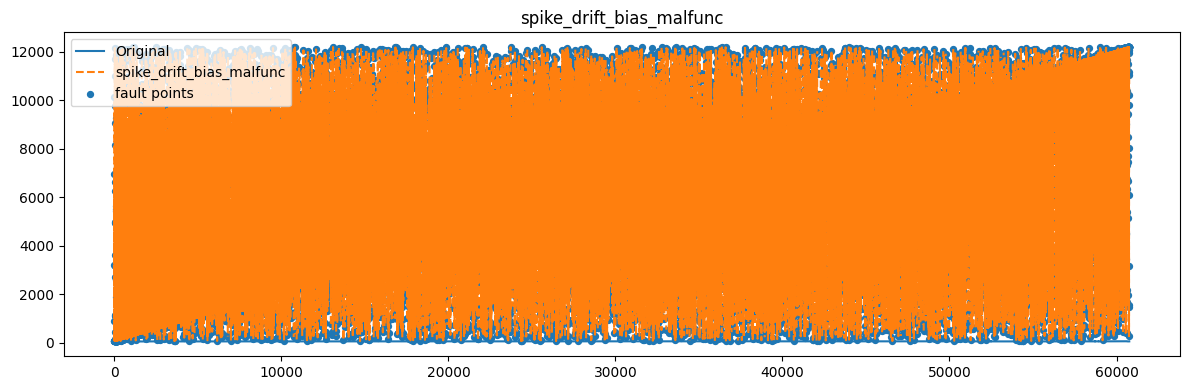

In [ ]:
# Skenario 5 (Hardened: never all-zero masks)

df_scenario_5 = df.copy()

# Compose multiple faults
y_all, m_all = simulate_multiple_faults(
    df_scenario_5[base].to_numpy(),
    [
        (simulate_spike_fault,    {"intensity": 0.3, "p": 0.07}),
        (simulate_drift_fault,    {"intensity": 0.2}),
        (simulate_bias_fault,     {"bias": 0.5}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)

col_name = base + '_spike_drift_bias_malfunc'
df_scenario_5[col_name] = y_all
df_scenario_5['label_fault'] = m_all.astype(int)

# --- Hardened guard: ensure at least some positives
if df_scenario_5['label_fault'].sum() == 0:
    # Inject a stronger spike pattern and OR it in
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_5[base].to_numpy(), intensity=0.5, p=0.2, seed=1357
    )
    df_scenario_5[base+'_spike_strong'] = y_spike_strong
    df_scenario_5['label_fault'] = (df_scenario_5['label_fault'].values | m_spike_strong).astype(int)

    # If (extremely unlikely) still zero, flip a tiny random slice to positives
    if df_scenario_5['label_fault'].sum() == 0:
        rng = np.random.default_rng(2468)
        k = max(1, len(df_scenario_5)//200)  # ~0.5% of points
        idx = rng.choice(len(df_scenario_5), size=k, replace=False)
        lab = df_scenario_5['label_fault'].to_numpy()
        lab[idx] = 1
        df_scenario_5['label_fault'] = lab

# Plot
plot_with_mask(y_all, m_all, "spike_drift_bias_malfunc")


# Fault detection
*   Neural network 1 & 2 Layer



In [ ]:
from functools import partial
import time, psutil
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.optimize import least_squares

def sigmoid(z): return 1/(1+np.exp(-z))
def neural_net_predict(params, X, d, h1, h2, two_layers):
    i=0    W1=params[i:i+d*h1].reshape(d,h1); i+=d*h1    b1=params[i:i+h1].reshape(1,h1); i+=h1    if two_layers:        W2=params[i:i+h1*h2].reshape(h1,h2); i+=h1*h2        b2=params[i:i+h2].reshape(1,h2); i+=h2        W3=params[i:i+h2].reshape(h2,1); i+=h2        a1=np.tanh(X@W1+b1); a2=np.tanh(a1@W2+b2)    else:        W3=params[i:i+h1].reshape(h1,1); i+=h1        a2=np.tanh(X@W1+b1)    b3=np.array([[params[i]]])
    return sigmoid(a2@W3+b3)
def residuals(params, X, y, d, h1, h2, two_layers):    return (neural_net_predict(params, X, d, h1, h2, two_layers)-y).ravel()
def add_entropy_features_causal(df, base_cols, *, entropy_fn, entropy_name, scales=None, weights=None,                                window=None, step=16):    """    base_cols: list of column names or single string (for backward compatibility)    """    # Handle backward compatibility: convert string to list    
if isinstance(base_cols, str):
    base_cols = [base_cols]        all_ent_cols = []    df_result = df.copy()        
for base_col in base_cols:        s = df[base_col].astype(float).copy()        s_filled = s.ffill().bfill().to_numpy()
    if scales is None: scales = list(range(1,11))
    if window is None: window = max(256, 10*max(scales))        n=len(s_filled); m=len(scales)        feats = np.zeros((n, m), dtype=float)        for i in range(0, n, step):
    start = max(0, i - window + 1)            x = s_filled[start:i+1]            vals = entropy_fn(x, scales)
    if len(x) >= max(scales)
    else [0.0]*m            feats[i:min(i+step,n),:] = np.asarray(vals, float)
    if weights:            wvec = np.array([weights.get(sc, 1.0) for sc in scales], float)            feats *= wvec.reshape(1,-1)        cols = [f"{base_col}_{entropy_name}_s{s}" for s in scales]        df_result = pd.concat([df_result, pd.DataFrame(feats, columns=cols, index=df.index)], axis=1)        all_ent_cols.extend(cols)
    return df_result, all_ent_cols
def make_features(df, base_cols, label_col='label_fault', lag_k=10, include_base=False):
    x=df.copy()    for k in range(1, lag_k+1): x[f"{base_col}_lag{k}"]=x[base_col].shift(k)    x[f"{base_col}_diff"]=x[base_col].diff()    feats=[c for c in x.select_dtypes(include=[np.number]).columns           if c!=label_col and (include_base or c!=base_col)]    for c in list(feats):        if x[c].isna().any():            x[c+"_isna"]=x[c].isna().astype(int)            x[c]=x[c].fillna(x[c].median())            feats.append(c+"_isna")    mask=(~x[feats].isna().any(axis=1)) & x[label_col].notna()
    return x.loc[mask,feats].to_numpy(), x.loc[mask,label_col].astype(int).to_numpy().reshape(-1,1), feats, maskdef time_block_split(X,y,tr_frac=0.6,va_frac=0.2):
    n=len(X); i1=int(n*tr_frac); i2=int(n*(tr_frac+va_frac))
    return X[:i1],X[i1:i2],X[i2:],y[:i1],y[i1:i2],y[i2:]
def neural_network_detection(    faulty_df,    original_cols=None,    *,    target_col='label_fault',    base_signals=BASE_SIGNALS  
# Updated to use 4 input nodes,    use_two_layers=True,    h1_size=6,    h2_size=3,    
max_nfev=60,    lag_k=10,    include_base=False,    # entropy plug-in    entropy_fn=None,    entropy_name=None,    entropy_feature_weights=None,    scales=None,    entropy_window=None,    entropy_step=16,    use_lm=True,    hide_logging=False):
    df=faulty_df.copy()
    if target_col not in df.columns:        raise ValueError(f"'{target_col}' not found.")
    if df[target_col].nunique() < 2:        inferred = np.zeros(len(df), dtype=bool)        
# try: infer from any faulted versions of the base signal (value-difference)        base_vals = df[base_signal].to_numpy()        
for c in df.columns:            if c.startswith(f"{base_signal}_") and c != base_signal:                xc = df[c].to_numpy()                mask = ~np.isnan(xc) & ~np.isnan(base_vals) & (xc != base_vals)                inferred |= mask        if inferred.any() and inferred.sum() < len(inferred):            df[target_col] = inferred.astype(int)        else:            # fallback: derive by max deviation across fault columns            deltas = []            
for c in df.columns:                if c.startswith(f"{base_signal}_") and c != base_signal:                    xc = df[c].to_numpy()                    deltas.append(np.abs(xc - base_vals))
    if deltas:                D = np.nanmax(np.stack(deltas, axis=1), axis=1)                thr = np.nanpercentile(D, 80)                df[target_col] = (D > thr).astype(int)            else:                
# last fallback: quantile on base                thr = df[base_signal].quantile(0.90)                df[target_col] = (df[base_signal] > thr).astype(int)    # final guard: 
if still single-class, force a tiny minority class    if df[target_col].nunique() < 2:        rng = np.random.default_rng(9918)        n = len(df); k = max(1, n // 200)  
# ~0.5%        
if int(df[target_col].iloc[0]) == 1:            idx = rng.choice(n, size=k, replace=False); df.loc[idx, target_col] = 0        else:            idx = rng.choice(n, size=k, replace=False); df.loc[idx, target_col] = 1    ent_cols=[]    if entropy_fn is not None and entropy_name is not None:        df, ent_cols = add_entropy_features_causal(            df, base_signal,            entropy_fn=entropy_fn, entropy_name=entropy_name,            scales=scales, weights=entropy_feature_weights,            window=entropy_window, step=entropy_step        )    X_all,y_all,used_features,mask = make_features(df, base_signals, label_col=target_col, lag_k=lag_k, include_base=include_base)    idx = df.index[mask]    fault_classes = {'positive': idx[y_all.ravel()==1].tolist(),                     'normal':   idx[y_all.ravel()==0].tolist()}    X_tr,X_va,X_te,y_tr,y_va,y_te = time_block_split(X_all,y_all,tr_frac=0.6,va_frac=0.2)    scaler=StandardScaler().fit(X_tr)    X_tr=scaler.transform(X_tr); X_va=scaler.transform(X_va); X_te=scaler.transform(X_te)    d = X_tr.shape[1]    np.random.seed(42)    param_size = d*h1_size + h1_size + (h1_size*h2_size + h2_size if use_two_layers else 0) + (h2_size if use_two_layers else h1_size) + 1    p0=np.random.randn(param_size)
    if not use_lm: raise NotImplementedError("Only LM (use_lm=True) supported.")    proc=psutil.Process(); t0=time.time(); u0,s0=proc.cpu_times()[:2]    res=least_squares(residuals, p0, args=(X_tr, y_tr, d, h1_size, h2_size, use_two_layers), max_nfev=max_nfev, method='lm')    trained=res.x    dur=time.time()-t0; u1,s1=proc.cpu_times()[:2]    cpu_pct=((u1+s1)-(u0+s0))/(dur*psutil.cpu_count())*100    p_va=neural_net_predict(trained,X_va,d,h1_size,h2_size,use_two_layers).ravel()    ts=np.linspace(0.05,0.95,91); best_f1=-1; t_star=0.5    
for t in ts:        yhat=(p_va>t).astype(int); yv=y_va.ravel()        tp=((yv==1)&(yhat==1)).sum(); fp=((yv==0)&(yhat==1)).sum(); fn=((yv==1)&(yhat==0)).sum()        prec=tp/(tp+fp)
    if (tp+fp)>0 else 0.0; rec=tp/(tp+fn)
    if (tp+fn)>0 else 0.0        f1=2*prec*rec/(prec+rec)
    if (prec+rec)>0 else 0.0        if f1>best_f1: best_f1=f1; t_star=t    p_te=neural_net_predict(trained,X_te,d,h1_size,h2_size,use_two_layers).ravel()    results_df=pd.DataFrame({        'split': ['val']*len(p_va)+['test']*len(p_te),        'true_label': np.concatenate([y_va.ravel(), y_te.ravel()]),        'predicted_prob': np.concatenate([p_va, p_te]),    })    results_df['predicted_label']=(results_df['predicted_prob']>t_star).astype(int)    results_df['entropy']=-(results_df['predicted_prob']*np.log2(results_df['predicted_prob']+1e-8)                            +(1-results_df['predicted_prob'])*np.log2(1-results_df['predicted_prob']+1e-8))    results_df['uncertain']=results_df['entropy']>0.95    results_df.attrs['t_star']=float(t_star)    results_df.attrs['features']=used_features+ent_cols    if not hide_logging:        te_mask=(results_df['split']=='test').values        yt=results_df.loc[te_mask,'true_label'].to_numpy()        yh=results_df.loc[te_mask,'predicted_label'].to_numpy()        acc=(yt==yh).mean()        prec=precision_score(yt,yh,zero_division=0)        rec=recall_score(yt,yh,zero_division=0)        f1=f1_score(yt,yh,zero_division=0)        print(f"Chosen threshold (val): {t_star:.2f}")        print(f"[TEST] acc={acc:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}")        print(f"Train secs / CPU%: {dur:.2f} / {cpu_pct:.1f}")
    return fault_classes, results_df

In [ ]:
import matplotlib.pyplot as plt

def visualize_fault_classes(fault_classes, two_bar_if_leq2=True):
    counts = {k: len(v) for k, v in fault_classes.items()}
    nonempty = {k: c for k, c in counts.items()
    if c > 0}

    plt.figure()
    if two_bar_if_leq2 and len(nonempty) <= 2:
        normal = counts.get('normal', 0)
        faulty = sum(c for k, c in counts.items()
    if k != 'normal')
        plt.bar(['faulty','normal'], [faulty, normal], color=['#FF6F61', '
#6B5B95'])
    else:
        names = list(counts.keys())
        vals = [counts[k] for k in names]
        colors = plt.cm.tab20.colors[:len(names)]
        plt.bar(names, vals, color=colors)

    plt.ylabel('Sample Count')
    plt.xlabel('Fault Class')
    plt.title('Distribution of Fault Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# NN Grid search

In [ ]:
import os
os.environ.setdefault("OMP_NUM_THREADS","1")os.environ.setdefault("MKL_NUM_THREADS","1")os.environ.setdefault("OPENBLAS_NUM_THREADS","1")os.environ.setdefault("NUMEXPR_NUM_THREADS","1")
import time, platform
import numpy as np, pandas as pd
from sklearn.metrics import precision_recall_curve
from math import isnan
# ===================== Config =====================
BASE_SIGNALS = ["kelembaban1", "kelembaban2", "kelembaban3", "kelembaban4"]
BASE_SIGNAL = "kelembaban_tanah_persen"  
# Keep 
for backward compatibility
POS_FRAC=0.20
USE_ENTROPY=False
ENTROPY_FN=None
ENTROPY_NAME="edmfuzzy"
ENTROPY_WEIGHTS=None
SCALES=list(range(1,11))
# Search gridsgrid_h1=[3,5,8,12,16]grid_h2=[0,4,8,12]  
# keep 0 to represent "no second layer" in records
max_nfev=40
n_repeats=2
SEARCH_LAGS=2
FINAL_LAGS=5
early_margin=0.05
adaptive_first_repeat_floor=None
# Optimization: Adaptive max_nfev based on iteration
# 
Use fewer iterations 
for first repeat to speed up
MAX_NFEV_FIRST_REPEAT = max(20, max_nfev // 2)  # Faster first iteration
MAX_NFEV_SUBSEQUENT = max_nfev  
# Full iterations 
for subsequent repeats# ===================== Small helper =====================
def _coerce_int_series(s, default=0):    return pd.to_numeric(s, errors="coerce").fillna(default).astype(int)
# ===================== System Introspection =====================try:    import psutil    
_PROC=psutil.Process(os.getpid())    N_CPUS=psutil.cpu_count(logical=True) or 1    TOTAL_RAM_MB=psutil.virtual_memory().total/1024/1024    
def _rss_mb_once(): return _PROC.memory_info().rss/1024/1024    def _cpu_times_s():
    t=_PROC.cpu_times(); return float(getattr(t,"user",0.0)+getattr(t,"system",0.0))except Exception:    psutil=None    
import multiprocessing    
N_CPUS=multiprocessing.cpu_count()    TOTAL_RAM_MB=np.nan    
def _rss_mb_once():        if platform.system()=="Linux":            try:                with open(f"/proc/{os.getpid()}/status") as f:                    for line in f:                        if line.startswith("VmRSS:"):                            return float(line.split()[1])/1024.0            except: pass        return float("nan")    def _cpu_times_s(): return time.process_time()
# ===================== Prep & Metrics =====================
def _prepare_df_for_grid(df, base_signal=None, base_signals=None, pos_frac=POS_FRAC, n_lags=SEARCH_LAGS):
    label_col="label"    if (label_col not in df.columns) or (df[label_col].nunique()<2):
    thr=df[base_signal].quantile(1-pos_frac); df=df.copy()        df["label_auto"]=(df[base_signal]>=thr).astype(int)        label_col="label_auto"        print(f"[info] Using synthetic '{label_col}' | thr={thr:.4f} | pos_rate={df[label_col].mean():.3f}")    dfe=df.copy(); s=dfe[base_signal]    dfe[base_signal+"_diff"]=s.diff().fillna(0)    for k in range(1,n_lags+1): dfe[f"{base_signal}_lag{k}"]=s.shift(k)    num_cols=dfe.select_dtypes(include=[np.number]).columns.tolist()    exclude={"label","label_auto",base_signal}    original_cols=[c for c in num_cols if c not in exclude]    dfe=dfe.fillna(0)
    return dfe, label_col, original_colsdef _summarize_best_f1_from_arrays(y_true,p,ent_arr=None):    if len(np.unique(y_true))<2:        ent=float(np.nan)
    if ent_arr is None else float(np.nanmean(ent_arr))
    return 0.0,0.0,0.0,0.5,0.0,ent    precs,recs,thrs=precision_recall_curve(y_true,p)    f1s=2*precs*recs/(precs+recs+1e-12)    best_idx=int(np.nanargmax(f1s))    best_f1=float(f1s[best_idx])    best_t=float(thrs[best_idx])
    if best_idx<len(thrs)
    else 0.5    yhat=(p>best_t)    acc=float((yhat==y_true).mean())    prec=float(precs[best_idx]); rec=float(recs[best_idx])    ent=float(np.nan)
    if ent_arr is None else float(np.nanmean(ent_arr))
    return acc,prec,rec,best_t,best_f1,entdef _entropy_args():    return dict(entropy_fn=ENTROPY_FN,entropy_name=ENTROPY_NAME,entropy_feature_weights=ENTROPY_WEIGHTS,scales=SCALES)
    if USE_ENTROPY and ENTROPY_FN else {}
def _bucket_dataset_length(N):    if N<=5000: return 5000    if N<=7000: return 7000    if N<=10000: return 10000    return ">10000"
# ===================== Global best tracking =====================try:    from multiprocessing import Manager    _mgr=Manager()    _global_best_f1=_mgr.Value('d',0.0)except Exception:    class _Dummy:        
def __init__(self): self.value=0.0    _global_best_f1=_Dummy()
# ===================== Core Runner (records h1 & h2, single layer) - 
OPTIMIZED =====================def _run_config_avg(h1,h2,dfe,original_cols,label_col,ea,base_signal,n_repeats):
    accs=[];precs=[];recs=[];f1s=[];ents=[];ts=[]    for r in range(n_repeats):        
# Optimization: 
Use fewer iterations 
for first repeat to speed up        current_max_nfev = MAX_NFEV_FIRST_REPEAT if r == 0 else MAX_NFEV_SUBSEQUENT        # single-layer training; pass h2_size only 
for bookkeeping        _,res=neural_network_detection(            faulty_df=dfe, original_cols=original_cols,            use_two_layers=False, h1_size=h1, h2_size=h2,            max_nfev=current_max_nfev, use_lm=True, hide_logging=True,            target_col=label_col, base_signal=base_signal, **ea        )        te=res[res['split']=='test']        y_true=te["true_label"].to_numpy(dtype=np.int8)        p=te["predicted_prob"].to_numpy(dtype=np.float32)        ent_arr=te["entropy"].to_numpy(dtype=np.float32)
    if "entropy" in te.columns else None        acc,prec,rec,best_t,best_f1,ent=_summarize_best_f1_from_arrays(y_true,p,ent_arr)        accs.append(acc);precs.append(prec);recs.append(rec);f1s.append(best_f1);ents.append(ent);ts.append(best_t)        
# Enhanced early stopping: skip remaining repeats 
if first result is poor        if r==0:            if adaptive_first_repeat_floor is not None and best_f1<adaptive_first_repeat_floor:                # If first repeat is below floor, fill remaining with same values 
for averaging                for _ in range(n_repeats - len(accs)):                    accs.append(acc); precs.append(prec); recs.append(rec); f1s.append(best_f1); ents.append(ent); ts.append(best_t)                break            
# More aggressive early stopping: 
if significantly worse than best, skip remaining            if (best_f1+early_margin*1.5)<float(_global_best_f1.value) and _global_best_f1.value > 0.1:                # Fill remaining with current values                
for _ in range(n_repeats - len(accs)):                    accs.append(acc); precs.append(prec); recs.append(rec); f1s.append(best_f1); ents.append(ent); ts.append(best_t)                break    avg_f1=float(np.nanmean(f1s))
    if avg_f1>_global_best_f1.value: _global_best_f1.value=avg_f1    return dict(accuracy=float(np.nanmean(accs)),precision=float(np.nanmean(precs)),recall=float(np.nanmean(recs)),                f1_best=avg_f1,best_t=float(np.nanmean(ts)),avg_entropy=float(np.nanmean(ents)))
# ===================== Grid Runner with checkpoint (h1,h2) =====================
def run_grid_with_checkpoint(df,scenario_name,checkpoint_path="nn_grid_checkpoint.csv",n_jobs=None,backend="loky",n_lags=SEARCH_LAGS):    dfe,label_col,original_cols=_prepare_df_for_grid(df,n_lags=n_lags); ea=_entropy_args()    keys=[(int(h1),int(h2)) for h1 in grid_h1 for h2 in grid_h2]    done=set()
    if os.path.exists(checkpoint_path):        try:            prev=pd.read_csv(checkpoint_path)            prev=prev[(prev["scenario"]==scenario_name)]            if {"h1_size","h2_size"}.issubset(prev.columns):
    prev_h1=_coerce_int_series(prev["h1_size"], default=0)                prev_h2=_coerce_int_series(prev["h2_size"], default=0)                mask=pd.notna(prev_h1) & pd.notna(prev_h2)                done={(int(h1),int(h2)) for h1,h2 in zip(prev_h1[mask], prev_h2[mask])}            elif "h1_size" in prev.columns:                done=set()        except Exception:            pass    todo=[pair for pair in keys if pair not in done]    if not todo:        lb=pd.read_csv(checkpoint_path); lb=lb[lb["scenario"]==scenario_name].copy()
    if "h1_size" not in lb: lb["h1_size"]=np.nan        if "h2_size" not in lb: lb["h2_size"]=0        lb["h1_size"]=pd.to_numeric(lb["h1_size"], errors="coerce")        lb["h2_size"]=pd.to_numeric(lb["h2_size"], errors="coerce").fillna(0)        keep_cols=[c for c in lb.columns if c in {"scenario","h1_size","h2_size","accuracy","precision","recall","f1_best","best_t","avg_entropy","N","dataset_length","dataset_length_bucket","pos_rate","label_used","wall_time_s","cpu_time_s","cpu_percent","max_rss_mb","mem_percent"}]        lb=lb[keep_cols]        for c in ["accuracy","precision","recall","f1_best","avg_entropy","mem_percent"]:            if c in lb: lb[c]=lb[c].round(4)
    if "best_t" in lb: lb["best_t"]=lb["best_t"].round(3)
    if "cpu_percent" in lb: lb["cpu_percent"]=lb["cpu_percent"].round(1)
    if "max_rss_mb" in lb: lb["max_rss_mb"]=lb["max_rss_mb"].round(1)
    return lb.sort_values(by=["f1_best","accuracy","recall","precision"],ascending=False).reset_index(drop=True)    try:        
from joblib 
import Parallel, delayed        use_parallel=True        if n_jobs is None:            try:                phys=psutil.cpu_count(logical=False)
    if psutil else None                base=phys or N_CPUS//2 or N_CPUS            except: base=N_CPUS            
# Optimization: 
Use more cores 
for parallel processing, but cap at reasonable limit            n_jobs=min(max(2,base),min(12,N_CPUS))  
# 
Use at least 2 cores, up to 12 or available    except Exception:        use_parallel=False; 
n_jobs=1    t0_wall=time.perf_counter(); t0_cpu=_cpu_times_s()    N=len(dfe); pos_rate=float(dfe[label_col].mean()); ds_bucket=_bucket_dataset_length(N)    
def run_one(h1,h2):
    stats=_run_config_avg(h1,h2,dfe,original_cols,label_col,ea,BASE_SIGNAL,n_repeats)
    return dict(scenario=scenario_name,h1_size=h1,h2_size=h2,N=N,dataset_length=N,                    dataset_length_bucket=ds_bucket,pos_rate=pos_rate,label_used=label_col,**stats)
    if use_parallel:        # Optimization: 
Use batch_size to reduce overhead, verbose 
for progress tracking        results=Parallel(n_jobs=n_jobs,backend=("threading" if backend=="threading" else "loky"),                         prefer=("threads" if backend=="threading" else "processes"),                         batch_size=max(1, len(todo) // (n_jobs * 2)),  
# Batch processing to reduce overhead                         verbose=0)(  # Set to 1 
for progress output if needed            [delayed(run_one)(h1,h2) for (h1,h2) in todo]        )    else:        results=[run_one(h1,h2) for (h1,h2) in todo]    wall_dur=time.perf_counter()-t0_wall; cpu_dur=_cpu_times_s()-t0_cpu    rss1=_rss_mb_once(); max_rss=rss1 if not isnan(rss1)
    else np.nan    cpu_percent=(cpu_dur/wall_dur)/N_CPUS*100 if wall_dur>0 else 0.0    mem_percent=(max_rss/TOTAL_RAM_MB*100)
    if TOTAL_RAM_MB and not isnan(max_rss)
    else np.nan    df_new=pd.DataFrame(results)    df_new["h1_size"]=_coerce_int_series(df_new["h1_size"], default=0)    df_new["h2_size"]=_coerce_int_series(df_new["h2_size"], default=0)    df_new["wall_time_s"]=round(wall_dur,3); df_new["cpu_time_s"]=round(cpu_dur,3)    df_new["cpu_percent"]=round(cpu_percent,1); df_new["max_rss_mb"]=round(max_rss,1)
    if not isnan(max_rss)
    else np.nan    df_new["mem_percent"]=round(mem_percent,4)
    if not isnan(mem_percent)
    else np.nan    for c in ["accuracy","precision","recall","f1_best","avg_entropy","mem_percent"]:        if c in df_new: df_new[c]=df_new[c].round(4)
    if "best_t" in df_new: df_new["best_t"]=df_new["best_t"].round(3)
    if os.path.exists(checkpoint_path):        try:            old=pd.read_csv(checkpoint_path)
    if "h2_size" not in old: old["h2_size"]=0            all_rows=pd.concat([old,df_new],ignore_index=True)        except Exception:            all_rows=df_new    else:        all_rows=df_new    if "h2_size" not in all_rows: all_rows["h2_size"]=0    all_rows["h1_size"]=pd.to_numeric(all_rows["h1_size"], errors="coerce").fillna(0).astype(int)    all_rows["h2_size"]=pd.to_numeric(all_rows["h2_size"], errors="coerce").fillna(0).astype(int)    all_rows.to_csv(checkpoint_path,index=False)    lb=(all_rows[all_rows["scenario"]==scenario_name].copy()        .sort_values(by=["f1_best","accuracy","recall","precision"],ascending=False)        .reset_index(drop=True))
    return lb
# ===================== Helpers =====================
def _subsample_df(df, frac):    if frac>=1.0: return df    n=max(1000,int(len(df)*frac))
    return df.iloc[:n].copy()
# ===================== Two-stage (uses pairs, robust to NaNs) =====================
def run_grid_two_stage(df,scenario_name,checkpoint_path="nn_grid_checkpoint.csv",n_jobs=None,backend="loky",coarse_frac=0.25,coarse_repeats=1,top_k=3):    global n_repeats    
dfe_small=_subsample_df(df,coarse_frac)    n_repeats_orig=n_repeats    n_repeats=coarse_repeats    lb_stage1=run_grid_with_checkpoint(        dfe_small, scenario_name+" [stage1]",        checkpoint_path=checkpoint_path.replace(".csv","_stage1.csv"),        n_jobs=n_jobs, backend=backend, n_lags=SEARCH_LAGS    )    stage1_top=(lb_stage1.sort_values("f1_best",ascending=False)                .head(min(top_k,len(lb_stage1))).copy())
    if "h1_size" not in stage1_top: stage1_top["h1_size"]=np.nan    if "h2_size" not in stage1_top: stage1_top["h2_size"]=0    stage1_top["h1_size"]=pd.to_numeric(stage1_top["h1_size"], errors="coerce")
    if stage1_top["h1_size"].isna().all():        stage1_top["h1_size"]=grid_h1[0]    else:        stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])    stage1_top["h2_size"]=pd.to_numeric(stage1_top["h2_size"], errors="coerce").fillna(0)    stage1_top["h1_size"]=stage1_top["h1_size"].astype(int)    stage1_top["h2_size"]=stage1_top["h2_size"].astype(int)    keep_pairs=list(stage1_top[["h1_size","h2_size"]].itertuples(index=False, name=None))    original_grid_h1=list(grid_h1)    original_grid_h2=list(grid_h2)    try:        if keep_pairs:            kh1=sorted(set([h1 for (h1,_) in keep_pairs]))            kh2=sorted(set([h2 for (_,h2) in keep_pairs]))            globals()["grid_h1"]=kh1            globals()["grid_h2"]=kh2        n_repeats=n_repeats_orig        lb_full=run_grid_with_checkpoint(            df, scenario_name,            checkpoint_path=checkpoint_path, n_jobs=n_jobs, backend=backend, n_lags=FINAL_LAGS        )    finally:        globals()["grid_h1"]=original_grid_h1        globals()["grid_h2"]=original_grid_h2        n_repeats=n_repeats_orig    return lb_full, lb_stage1# ===================== Multi-scenario wrapper =====================
def run_all_scenarios(checkpoint_path="nn_grid_checkpoint.csv",n_jobs=None,backend="loky",two_stage=True,coarse_frac=0.25,coarse_repeats=1,top_k=3):
    scenarios=[]    for i in range(1,6):
    var=f"df_scenario_{i}"        if var in globals(): scenarios.append((f"Scenario {i}", globals()[var]))
    if not scenarios:        print("[warn] No scenarios found."); return None,None    all_lbs=[]; stage1_lbs=[]    for name,df in scenarios:        print(f"\n=== {name} ===")
    if two_stage:            lb, lb1=run_grid_two_stage(df,name,checkpoint_path=checkpoint_path,n_jobs=n_jobs,backend=backend,coarse_frac=coarse_frac,coarse_repeats=coarse_repeats,top_k=top_k)            stage1_lbs.append(lb1)        else:            lb=run_grid_with_checkpoint(df,name,checkpoint_path=checkpoint_path,n_jobs=n_jobs,backend=backend,n_lags=SEARCH_LAGS)        all_lbs.append(lb)        print("\nTop 5:"); print(lb.head(5).to_string(index=False))        print("\nBest config:\n", lb.iloc[0].to_dict())        safe_name=name.replace(' ','_').lower()        lb.to_csv(f"nn_grid_leaderboard_{safe_name}.csv",index=False)    combined=pd.concat(all_lbs,ignore_index=True)    combined["scenario_rank"]=combined.groupby("scenario")["f1_best"].rank(ascending=False,method="dense")    combined_sorted=combined.sort_values(by=["f1_best","accuracy","recall","precision"],ascending=False).reset_index(drop=True)    print("\n=== Combined top 10 by best 
F1 ==="); print(combined_sorted.head(10).to_string(index=False))    combined_sorted.to_csv("nn_grid_combined_leaderboard.csv",index=False)
    return combined_sorted, all_lbs
# ===================== Example usage =====================# lb = run_grid_with_checkpoint(df_scenario_1, "Scenario 1", checkpoint_path="nn_grid_checkpoint.csv", 
n_jobs=None, backend="loky", n_lags=SEARCH_LAGS)
# lb_full, lb_stage1 = run_grid_two_stage(df_scenario_1, "Scenario 1", checkpoint_path="nn_grid_checkpoint.csv", 
n_jobs=None, backend="loky", coarse_frac=0.25, coarse_repeats=1, top_k=3)combined_sorted, all_lbs = run_all_scenarios(checkpoint_path="nn_grid_checkpoint.csv", n_jobs=None, backend="loky", two_stage=True)


=== Scenario 1 ===
[info] Using synthetic 'label_auto' | thr=48.5000 | pos_rate=0.201


/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 1        8        0 60763           60763                >10000  0.209042 label_auto    0.9802     0.9649  0.9811   0.9729   0.949       0.1161     1064.854        4.62          0.2       613.1       4.7252
Scenario 1        8        4 60763           60763                >10000  0.209042 label_auto    0.9802     0.9649  0.9811   0.9729   0.949       0.1161     1064.854        4.62          0.2       613.1       4.7252
Scenario 1        8        8 60763           60763                >10000  0.209042 label_auto    0.9802     0.9649  0.9811   0.9729   0.949       0.1161     1064.854        4.62          0.2       613.1       4.7252

Best config:
 {'scenario': 'Scenario 1', 'h1_size': 8, 'h2_s

/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 2        3        0 60763           60763                >10000  0.209042 label_auto    0.9985     0.9961     1.0    0.998   0.939       0.0557      242.558        1.17          0.2       613.4       4.7272
Scenario 2        3        4 60763           60763                >10000  0.209042 label_auto    0.9985     0.9961     1.0    0.998   0.939       0.0557      242.558        1.17          0.2       613.4       4.7272
Scenario 2        3        8 60763           60763                >10000  0.209042 label_auto    0.9985     0.9961     1.0    0.998   0.939       0.0557      242.558        1.17          0.2       613.4       4.7272

Best config:
 {'scenario': 'Scenario 2', 'h1_size': 3, 'h2_s

/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 3        3        0 60763           60763                >10000  0.209042 label_auto    0.9986     0.9968  0.9997   0.9982   0.483       0.0093        345.8        1.74          0.3       613.6        4.729
Scenario 3        3        4 60763           60763                >10000  0.209042 label_auto    0.9986     0.9968  0.9997   0.9982   0.483       0.0093        345.8        1.74          0.3       613.6        4.729
Scenario 3        3        8 60763           60763                >10000  0.209042 label_auto    0.9986     0.9968  0.9997   0.9982   0.483       0.0093        345.8        1.74          0.3       613.6        4.729

Best config:
 {'scenario': 'Scenario 3', 'h1_size': 3, 'h2_s

/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 4        3        0 60763           60763                >10000  0.209042 label_auto    0.9974     0.9938  0.9992   0.9965   0.628       0.1007      287.717         1.4          0.2       613.8       4.7302
Scenario 4        3        4 60763           60763                >10000  0.209042 label_auto    0.9974     0.9938  0.9992   0.9965   0.628       0.1007      287.717         1.4          0.2       613.8       4.7302
Scenario 4        3        8 60763           60763                >10000  0.209042 label_auto    0.9974     0.9938  0.9992   0.9965   0.628       0.1007      287.717         1.4          0.2       613.8       4.7302

Best config:
 {'scenario': 'Scenario 4', 'h1_size': 3, 'h2_s

/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 5        3        0 60763           60763                >10000  0.209042 label_auto    0.9911     0.9851  0.9905   0.9878   0.846       0.1989      203.644        1.01          0.2       613.8       4.7304
Scenario 5        3        4 60763           60763                >10000  0.209042 label_auto    0.9911     0.9851  0.9905   0.9878   0.846       0.1989      203.644        1.01          0.2       613.8       4.7304
Scenario 5        3        8 60763           60763                >10000  0.209042 label_auto    0.9911     0.9851  0.9905   0.9878   0.846       0.1989      203.644        1.01          0.2       613.8       4.7304

Best config:
 {'scenario': 'Scenario 5', 'h1_size': 3, 'h2_s

## Variation Coefficient Analysis

In [ ]:
import numpy as np, pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
from IPython.display import display

print("=" * 60)
print("Computing Variation Coefficient")
print("=" * 60)

CSV_PATH="data.csv"
SIGNAL_COL="kelembaban_tanah_persen"
SCALES=[1,5,9,13,17]  # Updated sesuai permintaan Bu Luh
M=2
R_FRACTION=0.15
BOOTSTRAPS=100
BLOCK_LEN=64
MAX_VECTORS_SAMPEN=140
MAX_VECTORS_FUZZY=140
CMSE_MAX_OFFSETS=5
DOWNSAMPLE_TO=2048
rng=np.random.default_rng(2025)
JSD_BINS=50
METHOD_ORDER=["MSE","CMSE","FME","EDM-Fuzzy","JSD-Fuzzy"]
TARGET_LENGTHS=[2000,4000,10000]  # Updated sesuai permintaan Bu Luh
DISPLAY_MAX_ROWS=200000
DISPLAY_MAX_COLS=2000
CSV_FLOAT_FMT="%.12g"

def moving_block_bootstrap(x, block_len=64, rng=rng):
    n=len(x); k=int(np.ceil(n/block_len))+2; s=rng.integers(0,n,size=k); y=[]
    for i in s:
        blk=x[i:i+block_len]
        if len(blk)<block_len: blk=np.concatenate([blk,x[:block_len-len(blk)]])
        y.append(blk)
    if len(y)*block_len>=n: break
    return np.concatenate(y,axis=0)[:n]

def coarse_grain_nonoverlap(x,tau):
    n=(len(x)//tau)*tau
    return x[:n].reshape(-1,tau).mean(axis=1)
    if n>0 else np.array([],np.float32)

def coarse_grain_composite(x,tau):
    if tau==1: return [x.copy()]
    offs=range(tau)
    if tau<=CMSE_MAX_OFFSETS else np.linspace(0,tau-1,CMSE_MAX_OFFSETS).astype(int)
    xs=[]
    for k in offs:
        seg=x[k:]; n=(len(seg)//tau)*tau
        if n>0: xs.append(seg[:n].reshape(-1,tau).mean(axis=1))
    return xs if xs else [np.array([],np.float32)]

def _sample_indices(L,max_vectors):
    return np.arange(L)
    if L<=max_vectors else np.unique(np.linspace(0,L-1,max_vectors).astype(int))

def _dx_cheby(A): return np.max(np.abs(A[:,None,:]-A[None,:,:]),axis=2)
def _dx_euclid(A): return np.linalg.norm(A[:,None,:]-A[None,:,:],axis=2)

def _metrics_from_windows(Xm,Xm1,ix,iy,r,n,JSD_bins,scale=1):
    Xs,Xt=Xm[ix],Xm1[iy]
    DX=_dx_cheby(Xs)
DY=_dx_cheby(Xt)
    np.fill_diagonal(DX,np.inf); np.fill_diagonal(DY,np.inf)
    B=(DX<=r).sum(); A=(DY<=r).sum()
    nB=DX.size-len(Xs); nA=DY.size-len(Xt)
    mse=np.inf if (A==0 or B==0 or nA<=0 or nB<=0)
    else float(-np.log((A/nA)/((B/nB)+1e-12)+1e-12))
    SX=np.exp(-(DX**n)/(r+1e-12))
SY=np.exp(-(DY**n)/(r+1e-12))
    CX=np.sum(SX,axis=1)/(SX.shape[1]-1)
CY=np.sum(SY,axis=1)/(SY.shape[1]-1)
    pm,pm1=float(np.mean(CX)),float(np.mean(CY))
    fme=np.nan if (pm<=0 or pm1<=0)
    else float(-np.log((pm1/(pm+1e-12))+1e-12))
    maskX=~np.eye(SX.shape[0],dtype=bool); maskY=~np.eye(SY.shape[0],dtype=bool)
    sX=SX[maskX]; sY=SY[maskY]

    # Optimized JSD calculation with adaptive binning and better stability
    n_samples = min(len(sX), len(sY))
    # Adaptive binning: more bins 
for larger scales, fewer for small scales to reduce variance
    if scale <= 3:
        adaptive_bins = max(20, min(JSD_bins, n_samples // 10))
        # Stronger smoothing 
for small scales
        eps_base = 1e-8
        alpha_smooth = 0.1  # Laplacian smoothing factor
    elif scale <= 7:
        adaptive_bins = max(30, min(JSD_bins, n_samples // 8))
        eps_base = 1e-10
        alpha_smooth = 0.05
    else:
        adaptive_bins = JSD_bins
        eps_base = 1e-12
        alpha_smooth = 0.01

    # Clip values to [0,1] range 
for histogram
    sX_clipped = np.clip(sX, 0.0, 1.0)
    sY_clipped = np.clip(sY, 0.0, 1.0)

    # Compute histograms with adaptive bins
    P_counts, _ = np.histogram(sX_clipped, bins=adaptive_bins, range=(0,1))
    Q_counts, _ = np.histogram(sY_clipped, bins=adaptive_bins, range=(0,1))

    # Convert to float64 and apply Laplacian smoothing 
for stability
    P = P_counts.astype(np.float64)
    Q = Q_counts.astype(np.float64)

    # Laplacian smoothing: add alpha to each bin to prevent zero probabilities
    total_P = P.sum() + alpha_smooth * adaptive_bins
    total_Q = Q.sum() + alpha_smooth * adaptive_bins
    P = (P + alpha_smooth) / total_P
    Q = (Q + alpha_smooth) / total_Q

    # Compute Jensen-Shannon divergence with numerical stability
    M = 0.5 * (P + Q)
    # Avoid log(0) by ensuring M > 0 (guaranteed by smoothing)
    log_PM = np.log(np.maximum(P, eps_base) / np.maximum(M, eps_base))
    log_QM = np.log(np.maximum(Q, eps_base) / np.maximum(M, eps_base))
    js = float(0.5 * (np.sum(P * log_PM) + np.sum(Q * log_QM)) / np.log(2))

    # Ensure JS is finite and non-negative
    if not np.isfinite(js) or js < 0:
        js = 0.0

    DXe=_dx_euclid(Xs); DYe=_dx_euclid(Xt)
    np.fill_diagonal(DXe,np.inf); np.fill_diagonal(DYe,np.inf)
    Sxe=np.exp(-(DXe**n)/(r+1e-12)); Sye=np.exp(-(DYe**n)/(r+1e-12))
    Cxe=np.sum(Sxe,axis=1)/(Sxe.shape[1]-1); Cye=np.sum(Sye,axis=1)/(Sye.shape[1]-1)
    pme,pme1=float(np.mean(Cxe)),float(np.mean(Cye))
    edm=np.nan if (pme<=0 or pme1<=0)
    else float(-np.log((pme1/(pme+1e-12))+1e-12))
    return mse,fme,edm,js

def _prep_signal(s):
    x=pd.Series(s,dtype=np.float32)
    if x.isna().any():
    x=x.interpolate(limit_direction="both")
    x=x.to_numpy(np.float32)
    if DOWNSAMPLE_TO and len(x)>DOWNSAMPLE_TO:
        idx=np.linspace(0,len(x)-1,DOWNSAMPLE_TO).astype(int); x=x[idx]
    return x

def _cv_profiles(x):
    stacks={m:[] for m in METHOD_ORDER}
    for _ in range(BOOTSTRAPS):
    xb=moving_block_bootstrap(x,BLOCK_LEN,rng).astype(np.float32,copy=False)
        mse_vals=[]; cmse_vals=[]; fme_vals=[]; edm_vals=[]; jsd_vals=[]
        for t in SCALES:
            cg=coarse_grain_nonoverlap(xb,t)
    if len(cg)<M+2:
                mse_vals.append(np.nan); fme_vals.append(np.nan); edm_vals.append(np.nan); jsd_vals.append(np.nan); cmse_vals.append(np.nan); continue
            Xm=sliding_window_view(cg,M); Xm1=sliding_window_view(cg,M+1)
    if len(Xm)<2 or len(Xm1)<2:
                mse_vals.append(np.nan); fme_vals.append(np.nan); edm_vals.append(np.nan); jsd_vals.append(np.nan); cmse_vals.append(np.nan); continue
            r=R_FRACTION*np.nanstd(cg)+1e-12
            ix=_sample_indices(len(Xm),MAX_VECTORS_SAMPEN); iy=_sample_indices(len(Xm1),MAX_VECTORS_SAMPEN)
            mse,fme,edm,js=_metrics_from_windows(Xm,Xm1,ix,iy,r,2,JSD_BINS,scale=t)
            mse_vals.append(mse); fme_vals.append(fme); edm_vals.append(edm); jsd_vals.append(js)
            cgs=coarse_grain_composite(xb,t)
    if cgs:
                vals=[np.inf if len(c)<M+2 else _metrics_from_windows(sliding_window_view(c,M),sliding_window_view(c,M+1),_sample_indices(len(c)-M+1,min(MAX_VECTORS_SAMPEN,max(40,len(c)-1))),_sample_indices(len(c)-M,min(MAX_VECTORS_SAMPEN,max(40,len(c)-1))),R_FRACTION*np.nanstd(c)+1e-12,2,JSD_BINS,scale=t)[0] for c in cgs]
                cmse_vals.append(float(np.nanmean(vals))
    if len(vals)
    else np.nan)
            else:
                cmse_vals.append(np.nan)
        stacks["MSE"].append(np.asarray(mse_vals))
        stacks["CMSE"].append(np.asarray(cmse_vals))
        stacks["FME"].append(np.asarray(fme_vals))
        stacks["EDM-Fuzzy"].append(np.asarray(edm_vals))
        stacks["JSD-Fuzzy"].append(np.asarray(jsd_vals))
    cvs={}
    for m in METHOD_ORDER:
        V=np.vstack(stacks[m]); mu=np.nanmean(V,axis=0); sd=np.nanstd(V,axis=0,ddof=1)
        cvs[m]=sd/(np.abs(mu)+1e-12)
    return cvs

def _infer_fault(df):
    # First try to find label_fault column
    if "label_fault" in df.columns:
        s = df["label_fault"].dropna()
    if len(s) > 0:
            pos_rate = s.mean()
    if pos_rate > 0.01:  # If more than 1% are faults
                return "Fault"
            else:
                return "Normal"

    # Try other fault/label columns
    c = [k for k in df.columns if k.lower() in ("fault", "label", "class", "status")]
    if c:
        s = df[c[0]].dropna()
    if len(s) > 0:
            v = s.mode().iat[0] if len(s.mode()) > 0 else None
            if v is not None:
                if isinstance(v, str):
                    return v
                try:
                    return "Fault" if int(v) == 1 else "Normal"
                except:
                    return str(v)

    # Try to infer from signal column names
    signal_cols = [col for col in df.columns if is_signal_col(col)]
    for col in signal_cols:
        if col != SIGNAL_COL and col.startswith(SIGNAL_COL + "_"):
    fault_type = col.replace(SIGNAL_COL + "_", "")
    if fault_type in ["drift", "spike", "hardware", "bias"]:
                return fault_type.capitalize()
            elif "drift" in fault_type or "spike" in fault_type:
                return "Mixed"

    return "Unknown"

def _truncate_df(df, n): return df.iloc[:min(len(df), n)].copy()

def is_signal_col(c):
    lc=c.lower()
    if c==SIGNAL_COL or c.startswith(SIGNAL_COL+"_"):
        return ("_bias" not in lc) and ("_malfunc" not in lc)
    return False

def show_and_save(df, name, folder=".", round_decimals=None):
    d=df.copy()
    if round_decimals is not None: d=d.round(round_decimals)
    with pd.option_context("display.max_rows",DISPLAY_MAX_ROWS,"display.max_columns",DISPLAY_MAX_COLS,"display.width",None,"display.expand_frame_repr",True,"display.max_colwidth",None):
        display(d)
    csv_path=f"{folder.rstrip('/')}/{name}.csv"
    xlsx_path=f"{folder.rstrip('/')}/{name}.xlsx"
    d.to_csv(csv_path, index=True, float_format=CSV_FLOAT_FMT)
    with pd.ExcelWriter(xlsx_path) as w:
        d.to_excel(w, sheet_name="Sheet1")
        try:
            ws=w.sheets["Sheet1"]
            widths=[max(10,int(pd.Index(d.index.astype(str)).map(len).max()))]+[max(10,int(d[c].astype(str).map(len).max())) for c in d.columns]
            for i,width in enumerate([min(50,w) for w in widths]): ws.set_column(i,i,width)
        except Exception: pass
    print(f"Saved to: {csv_path} and {xlsx_path}")

# Buat data khusus untuk perbandingan CV (bukan dari scenario 1-5)
# Sesuai permintaan Bu Luh: CV dipakai untuk menilai dalam satu kelas yang seharusnya seragam,
# entropy X stabil nggak? Data yang diuji adalah CV untuk tipe data yang sejenis.

print("Membuat data khusus untuk perbandingan CV...")
print("Data ini terpisah dari scenario 1-5 yang digunakan untuk training/testing")

# 1. Normal data (data asli tanpa fault)
df_cv_normal = df.copy()
df_cv_normal[SIGNAL_COL + "_normal"] = df_cv_normal[SIGNAL_COL]

# 2. Spike data
y_spike_cv, _ = simulate_spike_fault(df[SIGNAL_COL].to_numpy(), intensity=0.3, p=0.07, seed=100)
df_cv_spike = df.copy()
df_cv_spike[SIGNAL_COL + "_spike"] = y_spike_cv

# 3. Drift data
y_drift_cv, _ = simulate_drift_fault(df[SIGNAL_COL].to_numpy(), intensity=0.15, seed=101)
df_cv_drift = df.copy()
df_cv_drift[SIGNAL_COL + "_drift"] = y_drift_cv

# 4. Bias data
y_bias_cv, _ = simulate_bias_fault(df[SIGNAL_COL].to_numpy(), bias=0.35, seed=102)
df_cv_bias = df.copy()
df_cv_bias[SIGNAL_COL + "_bias"] = y_bias_cv

# 5. Malfunction data
y_malfunc_cv, _ = simulate_hardware_fault(df[SIGNAL_COL].to_numpy(), stuck_prob=0.2, loss_prob=0.1, seed=103)
df_cv_malfunc = df.copy()
df_cv_malfunc[SIGNAL_COL + "_malfunction"] = y_malfunc_cv

# 6. Drift + Bias + Spike + Malfunction data
y_all_cv, _ = simulate_multiple_faults(
    df[SIGNAL_COL].to_numpy(),
    [
        (simulate_drift_fault, {"intensity": 0.15}),
        (simulate_bias_fault, {"bias": 0.35}),
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_hardware_fault, {"stuck_prob": 0.2, "loss_prob": 0.1})
    ],
    seed=104
)
df_cv_all = df.copy()
df_cv_all[SIGNAL_COL + "_all_faults"] = y_all_cv

# Mapping untuk CV comparison
cv_scenarios_base = [
    ("Normal", df_cv_normal, SIGNAL_COL + "_normal"),
    ("Spike", df_cv_spike, SIGNAL_COL + "_spike"),
    ("Drift", df_cv_drift, SIGNAL_COL + "_drift"),
    ("Bias", df_cv_bias, SIGNAL_COL + "_bias"),
    ("Malfunction", df_cv_malfunc, SIGNAL_COL + "_malfunction"),
    ("Drift+Bias+Spike+Malfunction", df_cv_all, SIGNAL_COL + "_all_faults"),
]

scenarios=[]
for scen_name, df_cv, signal_col in cv_scenarios_base:
    for n in TARGET_LENGTHS:
        df_truncated = _truncate_df(df_cv, n)
        # Pastikan kolom signal yang benar ada di dataframe
        scenarios.append((f"{scen_name} (N={n})", df_truncated, signal_col))

scenario_meta={}
for name, d, sig_col in scenarios:
    fault_type = name.split()[0]  # Extract fault type from scenario name (e.g., "Normal", "Spike", etc.)
    scenario_meta[name] = {"N": int(len(d)), "Fault": fault_type}

rows=[]
total_combinations = len(scenarios) * len(METHOD_ORDER) * len(SCALES)
current = 0
for scen_name, d, signal_col in scenarios:
    # Gunakan signal_col yang sudah ditentukan untuk setiap scenario
    if signal_col not in d.columns:
        print(f"Skipping [{scen_name}]: signal column {signal_col} not found")
        # Add NaN rows 
for this scenario
        for m in METHOD_ORDER:
            for sc in SCALES:
                rows.append({"Scenario":scen_name,"Signal":signal_col,"Method":m,"Scale":sc,"CV":np.nan,"N":scenario_meta[scen_name]["N"],"Fault":scenario_meta[scen_name]["Fault"]})
        continue

    if d[signal_col].isna().all():
        print(f"Skipping [{scen_name} - {signal_col}]: column is all NaN")
        # Add NaN rows 
for this scenario
        for m in METHOD_ORDER:
            for sc in SCALES:
                rows.append({"Scenario":scen_name,"Signal":signal_col,"Method":m,"Scale":sc,"CV":np.nan,"N":scenario_meta[scen_name]["N"],"Fault":scenario_meta[scen_name]["Fault"]})
        continue

    current += 1
    print(f"Processing [{current}/{total_combinations}]: {scen_name} - {signal_col}")
    try:
        signal_data = _prep_signal(d[signal_col])
    if len(signal_data) < max(SCALES) * 2:  # Need enough data 
for processing
            print(f"  Warning: Insufficient data for {signal_col} (length={len(signal_data)})")
            # Still process but may get NaN results
        cvs = _cv_profiles(signal_data)
        for m in METHOD_ORDER:
            for sc, val in zip(SCALES, cvs[m]):
                rows.append({"Scenario":scen_name,"Signal":signal_col,"Method":m,"Scale":sc,"CV":float(val),"N":scenario_meta[scen_name]["N"],"Fault":scenario_meta[scen_name]["Fault"]})
    except Exception as e:
        print(f"  Error processing {signal_col}: {e}")
        # Add NaN rows 
for this signal-method combination
        for m in METHOD_ORDER:
            for sc in SCALES:
                rows.append({"Scenario":scen_name,"Signal":signal_col,"Method":m,"Scale":sc,"CV":np.nan,"N":scenario_meta[scen_name]["N"],"Fault":scenario_meta[scen_name]["Fault"]})

print(f"\nCompleted processing {len(scenarios)} scenarios (total {total_combinations} scenario-method-scale combinations).")
print("Creating pivot tables...")

df_cv=pd.DataFrame(rows)

# Only include signals that actually have data (not all NaN)
df_cv_clean = df_cv.dropna(subset=["CV"], how="all").copy()

# Get signals that actually exist per scenario
scenario_signals = {}
for scen_name, d, sig_col in scenarios:
    scenario_signals[scen_name] = {sig_col}  # Each scenario has one specific signal column

# Create MultiIndex only 
for combinations that exist
valid_combinations = []
for scen_name, sigs in scenario_signals.items():
    for sig in sigs:
        for method in METHOD_ORDER:
            valid_combinations.append((scen_name, sig, method))

mi_ssm = pd.MultiIndex.from_tuples(valid_combinations, names=["Scenario","Signal","Method"])
pivot_ssm = (df_cv_clean.pivot_table(index=["Scenario","Signal","Method"], columns="Scale", values="CV")
             .reindex(index=mi_ssm)
             .reindex(columns=[s for s in SCALES if s in df_cv_clean["Scale"].unique()]))

# For scenario-method pivot, only include scenarios that have data
mi_sm = pd.MultiIndex.from_product([[s for s,_,_ in scenarios], METHOD_ORDER], names=["Scenario","Method"])
pivot_sm = (df_cv_clean.groupby(["Scenario","Method","Scale"], as_index=False)["CV"].mean()
            .pivot_table(index=["Scenario","Method"], columns="Scale", values="CV")
            .reindex(index=mi_sm)
            .reindex(columns=[s for s in SCALES if s in df_cv_clean["Scale"].unique()]))

# Remove rows that are all NaN
pivot_ssm = pivot_ssm.dropna(how="all")
pivot_sm = pivot_sm.dropna(how="all")

pivot_method=(df_cv.groupby(["Method","Scale"],as_index=False)["CV"].mean()
                .pivot_table(index="Method",columns="Scale",values="CV")
                .reindex(index=METHOD_ORDER)
                .reindex(columns=[s for s in SCALES if s in df_cv["Scale"].unique()]))

meta_df=pd.DataFrame(scenario_meta).T; meta_df.index.name="Scenario"
pivot_sm_with_meta=pivot_sm.copy()
pivot_sm_with_meta["N"]=pivot_sm_with_meta.index.get_level_values("Scenario").map(meta_df["N"])
pivot_sm_with_meta["Fault"]=pivot_sm_with_meta.index.get_level_values("Scenario").map(meta_df["Fault"])
pivot_sm_with_meta=pivot_sm_with_meta[["N","Fault"]+[c for c in pivot_sm.columns]]

pivot_ssm_with_meta=pivot_ssm.copy()
pivot_ssm_with_meta["N"]=pivot_ssm_with_meta.index.get_level_values("Scenario").map(meta_df["N"])
pivot_ssm_with_meta["Fault"]=pivot_ssm_with_meta.index.get_level_values("Scenario").map(meta_df["Fault"])

print("\n" + "=" * 60)
print("Data Quality Summary")
print("=" * 60)
print(f"Total rows in df_cv: {len(df_cv)}")
print(f"Rows with valid CV values: {df_cv['CV'].notna().sum()}")
print(f"Rows with NaN CV values: {df_cv['CV'].isna().sum()}")
print(f"\nPivot table (scenario-method) shape: {pivot_sm_with_meta.shape}")
print(f"NaN values in pivot_sm_with_meta: {pivot_sm_with_meta.isna().sum().sum()}")
print(f"Percentage of NaN: {100 * pivot_sm_with_meta.isna().sum().sum() / pivot_sm_with_meta.size:.2f}%")
print(f"\nPivot table (scenario-signal-method) shape: {pivot_ssm_with_meta.shape}")
print(f"NaN values in pivot_ssm_with_meta: {pivot_ssm_with_meta.isna().sum().sum()}")
print(f"Percentage of NaN: {100 * pivot_ssm_with_meta.isna().sum().sum() / pivot_ssm_with_meta.size:.2f}%")

# Show fault type distribution
print(f"\nFault type distribution:")
fault_counts = df_cv.groupby(["Scenario", "Fault"]).size().reset_index(name="count")
for scen in df_cv["Scenario"].unique():
    scen_faults = fault_counts[fault_counts["Scenario"] == scen]
    print(f"  {scen}:")
    for _, row in scen_faults.iterrows():
        print(f"    {row['Fault']}: {row['count']} rows")

print("\n" + "=" * 60)
print("Saving results...")
print("=" * 60)

show_and_save(pivot_sm_with_meta, "cv_entropy_scenario_method_with_meta")
show_and_save(pivot_ssm_with_meta, "cv_entropy_scenario_signal_method_with_meta")

# Optional: Create cleaned versions without rows that are all NaN (except meta columns)
pivot_sm_clean = pivot_sm_with_meta.dropna(subset=[c for c in pivot_sm_with_meta.columns if c not in ["N", "Fault"]], how="all")
pivot_ssm_clean = pivot_ssm_with_meta.dropna(subset=[c for c in pivot_ssm_with_meta.columns if c not in ["N", "Fault"]], how="all")
    if len(pivot_sm_clean) < len(pivot_sm_with_meta):
    print(f"\nNote: Created cleaned version with {len(pivot_sm_clean)} rows (removed {len(pivot_sm_with_meta) - len(pivot_sm_clean)} all-NaN rows)")
    show_and_save(pivot_sm_clean, "cv_entropy_scenario_method_with_meta_clean")
    show_and_save(pivot_ssm_clean, "cv_entropy_scenario_signal_method_with_meta_clean")

#show_and_save(pivot_sm, "cv_entropy_scenario_method")
#show_and_save(pivot_ssm, "cv_entropy_scenario_signal_method")
#show_and_save(pivot_method, "cv_entropy_method_overall")


Computing Variation Coefficient
Membuat data khusus untuk perbandingan CV...
Data ini terpisah dari scenario 1-5 yang digunakan untuk training/testing
Processing [1/450]: Normal (N=2000) - kelembaban_tanah_persen_normal
Processing [2/450]: Normal (N=4000) - kelembaban_tanah_persen_normal
Processing [3/450]: Normal (N=10000) - kelembaban_tanah_persen_normal
Processing [4/450]: Spike (N=2000) - kelembaban_tanah_persen_spike
Processing [5/450]: Spike (N=4000) - kelembaban_tanah_persen_spike
Processing [6/450]: Spike (N=10000) - kelembaban_tanah_persen_spike
Processing [7/450]: Drift (N=2000) - kelembaban_tanah_persen_drift
Processing [8/450]: Drift (N=4000) - kelembaban_tanah_persen_drift
Processing [9/450]: Drift (N=10000) - kelembaban_tanah_persen_drift
Processing [10/450]: Bias (N=2000) - kelembaban_tanah_persen_bias
Processing [11/450]: Bias (N=4000) - kelembaban_tanah_persen_bias
Processing [12/450]: Bias (N=10000) - kelembaban_tanah_persen_bias
Processing [13/450]: Malfunction (N=20

/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Processing [17/450]: Drift+Bias+Spike+Malfunction (N=4000) - kelembaban_tanah_persen_all_faults


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Processing [18/450]: Drift+Bias+Spike+Malfunction (N=10000) - kelembaban_tanah_persen_all_faults

Completed processing 18 scenarios (total 450 scenario-method-scale combinations).
Creating pivot tables...

Data Quality Summary
Total rows in df_cv: 450
Rows with valid CV values: 448
Rows with NaN CV values: 2

Pivot table (scenario-method) shape: (90, 7)
NaN values in pivot_sm_with_meta: 2
Percentage of NaN: 0.32%

Pivot table (scenario-signal-method) shape: (90, 7)
NaN values in pivot_ssm_with_meta: 2
Percentage of NaN: 0.32%

Fault type distribution:
  Normal (N=2000):
    Normal: 25 rows
  Normal (N=4000):
    Normal: 25 rows
  Normal (N=10000):
    Normal: 25 rows
  Spike (N=2000):
    Spike: 25 rows
  Spike (N=4000):
    Spike: 25 rows
  Spike (N=10000):
    Spike: 25 rows
  Drift (N=2000):
    Drift: 25 rows
  Drift (N=4000):
    Drift: 25 rows
  Drift (N=10000):
    Drift: 25 rows
  Bias (N=2000):
    Bias: 25 rows
  Bias (N=4000):
    Bias: 25 rows
  Bias (N=10000):
    Bias: 25

Scale                                                 N  \
Scenario                               Method             
Normal (N=2000)                        MSE         2000   
                                       CMSE        2000   
                                       FME         2000   
                                       EDM-Fuzzy   2000   
                                       JSD-Fuzzy   2000   
Normal (N=4000)                        MSE         4000   
                                       CMSE        4000   
                                       FME         4000   
                                       EDM-Fuzzy   4000   
                                       JSD-Fuzzy   4000   
Normal (N=10000)                       MSE        10000   
                                       CMSE       10000   
                                       FME        10000   
                                       EDM-Fuzzy  10000   
                                       JSD-Fuzzy  10000   
Spike (N=2000)                         MSE         2000   
                                       CMSE        2000   
                                       FME         2000   
                                       EDM-Fuzzy   2000   
                                       JSD-Fuzzy   2000   
Spike (N=4000)                         MSE         4000   
                                       CMSE        4000   
                                       FME         4000   
                                       EDM-Fuzzy   4000   
                                       JSD-Fuzzy   4000   
Spike (N=10000)                        MSE        10000   
                                       CMSE       10000   
                                       FME        10000   
                                       EDM-Fuzzy  10000   
                                       JSD-Fuzzy  10000   
Drift (N=2000)                         MSE         2000   
                                       CMSE        2000   
                                       FME         2000   
                                       EDM-Fuzzy   2000   
                                       JSD-Fuzzy   2000   
Drift (N=4000)                         MSE         4000   
                                       CMSE        4000   
                                       FME         4000   
                                       EDM-Fuzzy   4000   
                                       JSD-Fuzzy   4000   
Drift (N=10000)                        MSE        10000   
                                       CMSE       10000   
                                       FME        10000   
                                       EDM-Fuzzy  10000   
                                       JSD-Fuzzy  10000   
Bias (N=2000)                          MSE         2000   
                                       CMSE        2000   
                                       FME         2000   
                                       EDM-Fuzzy   2000   
                                       JSD-Fuzzy   2000   
Bias (N=4000)                          MSE         4000   
                                       CMSE        4000   
                                       FME         4000   
                                       EDM-Fuzzy   4000   
                                       JSD-Fuzzy   4000   
Bias (N=10000)                         MSE        10000   
                                       CMSE       10000   
                                       FME        10000   
                                       EDM-Fuzzy  10000   
                                       JSD-Fuzzy  10000   
Malfunction (N=2000)                   MSE         2000   
                                       CMSE        2000   
                                       FME         2000   
                                       EDM-Fuzzy   2000   
                                       JSD-Fuzzy   2000   
Malfunction (N=4000)                   MSE     

Saved to: ./cv_entropy_scenario_method_with_meta.csv and ./cv_entropy_scenario_method_with_meta.xlsx


Scale                                                                                        1  \
Scenario                               Signal                              Method                
Normal (N=2000)                        kelembaban_tanah_persen_normal      MSE        0.662830   
                                                                           CMSE       0.662830   
                                                                           FME        0.262762   
                                                                           EDM-Fuzzy  0.169803   
                                                                           JSD-Fuzzy  0.389810   
Normal (N=4000)                        kelembaban_tanah_persen_normal      MSE        0.622984   
                                                                           CMSE       0.622984   
                                                                           FME        0.220854   
                                                                           EDM-Fuzzy  0.149247   
                                                                           JSD-Fuzzy  0.339681   
Normal (N=10000)                       kelembaban_tanah_persen_normal      MSE        0.464874   
                                                                           CMSE       0.464874   
                                                                           FME        0.196412   
                                                                           EDM-Fuzzy  0.133718   
                                                                           JSD-Fuzzy  0.251691   
Spike (N=2000)                         kelembaban_tanah_persen_spike       MSE        0.494944   
                                                                           CMSE       0.494944   
                                                                           FME        0.231968   
                                                                           EDM-Fuzzy  0.162975   
                                                                           JSD-Fuzzy  0.355868   
Spike (N=4000)                         kelembaban_tanah_persen_spike       MSE        0.493610   
                                                                           CMSE       0.493610   
                                                                           FME        0.195287   
                                                                           EDM-Fuzzy  0.143992   
                                                                           JSD-Fuzzy  0.284225   
Spike (N=10000)                        kelembaban_tanah_persen_spike       MSE        0.423296   
                                                                           CMSE       0.423296   
                                                                           FME        0.183405   
                                                                           EDM-Fuzzy  0.138883   
                                                                           JSD-Fuzzy  0.275357   
Drift (N=2000)                         kelembaban_tanah_persen_drift       MSE        0.296102   
                                                                           CMSE       0.296102   
                                                                           FME        0.236845   
                                                                           EDM-Fuzzy  0.105714   
                                                                           JSD-Fuzzy  0.223820   
Drift (N=4000)                         kelembaban_tanah_persen_drift       MSE        0.293459   
                                                                           CMSE       0.293459   
                                                                           FME        0.283176   
                                                                           EDM-F

Saved to: ./cv_entropy_scenario_signal_method_with_meta.csv and ./cv_entropy_scenario_signal_method_with_meta.xlsx


# Jensen-Shannon Entropy:

In [ ]:
from scipy.spatial.distance import jensenshannon

def coarse_grain(x, s):
    import numpy as np
    return np.array([x[i:i+s].mean() for i in range(0, len(x) - s + 1, s)])

def multiscale_jsd_entropy(x, scales, reference=None, bins=20):
    import numpy as np
    if reference is None:
        reference = x
    return [
        jensenshannon(
            np.histogram(coarse_grain(x, sc), bins=bins, density=True)[0],
            np.histogram(coarse_grain(reference, sc), bins=bins, density=True)[0],
            base=2
        )
    if len(coarse_grain(x, sc)) > 1 else 0.0
        for sc in scales
    ]

jsd_entropy_fn = lambda x, scales: multiscale_jsd_entropy(x, scales)

# multiscale_fuzzy_entropy

In [ ]:
import numpy as np

def coarse_grain(x, s):
    return np.array([x[i:i+s].mean() for i in range(0, len(x) - s + 1, s)])

def fuzzy_entropy(x, m, n, r):
    N = len(x)
    phi = []
    for mm in (m, m + 1):
    patterns = [x[i:i+mm] for i in range(N - mm + 1)]
        C = []
        for i, pat in enumerate(patterns):
    d = [np.max(np.abs(pat - other)) for j, other in enumerate(patterns)
    if j != i]
            if len(d) == 0:
                C.append(0.0)
            else:
                C.append(np.sum(np.exp(-np.power(d, n) / (r + 1e-8))) / len(d))
        denom = N - mm + 1
        phi_val = np.sum(C) / denom if denom > 0 else 0.0
        phi.append(phi_val)
    if phi[0] == 0 or phi[1] == 0:
        return 0.0
    return -np.log((phi[1] / (phi[0] + 1e-8)) + 1e-8)

def multiscale_fuzzy_entropy(x, scales, m=2, n=2, r=None):
    if r is None:
        r = 0.15 * np.std(x)
    return [fuzzy_entropy(coarse_grain(x, sc), m, n, r)
    if len(coarse_grain(x, sc)) > 0 else 0.0 for sc in scales]


# Edm fuzzy

In [ ]:
import numpy as np

def coarse_grain(x, s):
    return np.array([x[i:i+s].mean() for i in range(0, len(x) - s + 1, s)])

def fuzzy_entropy(x, m, n, r):
    N = len(x)
    phi = []
    for mm in (m, m + 1):
        if N < mm + 1:
            phi.append(0.0)
            continue
        patterns = np.array([x[i:i+mm] for i in range(N - mm + 1)])
    if len(patterns) < 2:
            phi.append(0.0)
            continue
        D = np.linalg.norm(patterns[:, None] - patterns[None, :], axis=2)
        np.fill_diagonal(D, np.inf)
        sim = np.exp(-np.power(D, n) / (r + 1e-8))
        C = np.sum(sim, axis=1) / (len(patterns) - 1)
        C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
        phi_val = np.mean(C)
    if len(C) > 0 else 0.0
        phi.append(phi_val)
    if phi[0] == 0 or phi[1] == 0:
        return 0.0
    return -np.log((phi[1] / (phi[0] + 1e-8)) + 1e-8)

def edm_fuzzy(x, scales=None, m=2, n=2, r=None):
    if r is None:
        r = 0.15 * np.std(x)
    if scales is None:
        scales = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
    results = []
    for sc in scales:
        cg = coarse_grain(x, sc)
    if len(cg) > m + 1:
            fe = fuzzy_entropy(cg, m, n, r)
            results.append(0.0 if not np.isfinite(fe)
    else fe)
        else:
            results.append(0.0)
    return results


# Neural network 2 Layer -> Scenario 1 + 2 JST, Scenario 3 JSD

Chosen threshold (val): 0.05
[TEST] acc=0.9984 prec=0.9829 rec=0.9954 f1=0.9891
Train secs / CPU%: 505.64 / 78.4
{'positive': [0, 14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 182, 196, 210, 224, 238, 252, 266, 280, 294, 308, 322, 336, 350, 364, 378, 392, 406, 420, 434, 448, 462, 476, 490, 504, 518, 532, 546, 560, 574, 588, 602, 616, 630, 644, 658, 672, 686, 700, 714, 728, 742, 756, 770, 784, 798, 812, 826, 840, 854, 868, 882, 896, 910, 924, 938, 952, 966, 980, 994, 1008, 1022, 1036, 1050, 1064, 1078, 1092, 1106, 1120, 1134, 1148, 1162, 1176, 1190, 1204, 1218, 1232, 1246, 1260, 1274, 1288, 1302, 1316, 1330, 1344, 1358, 1372, 1386, 1400, 1414, 1428, 1442, 1456, 1470, 1484, 1498, 1512, 1526, 1540, 1554, 1568, 1582, 1596, 1610, 1624, 1638, 1652, 1666, 1680, 1694, 1708, 1722, 1736, 1750, 1764, 1778, 1792, 1806, 1820, 1834, 1848, 1862, 1876, 1890, 1904, 1918, 1932, 1946, 1960, 1974, 1988, 2002, 2016, 2030, 2044, 2058, 2072, 2086, 2100, 2114, 2128, 2142, 2156, 2170, 2184, 2198, 2212, 

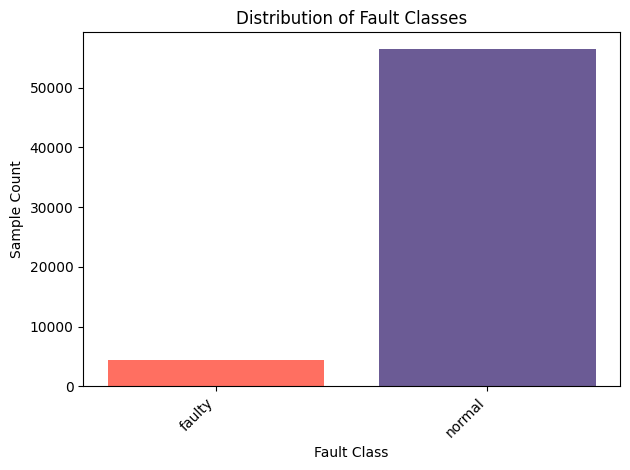

Chosen threshold (val): 0.05
[TEST] acc=0.0000 prec=0.0000 rec=0.0000 f1=0.0000
Train secs / CPU%: 794.52 / 77.1
{'positive': [48610, 48611, 48612, 48613, 48614, 48615, 48616, 48617, 48618, 48619, 48620, 48621, 48622, 48623, 48624, 48625, 48626, 48627, 48628, 48629, 48630, 48631, 48632, 48633, 48634, 48635, 48636, 48637, 48638, 48639, 48640, 48641, 48642, 48643, 48644, 48645, 48646, 48647, 48648, 48649, 48650, 48651, 48652, 48653, 48654, 48655, 48656, 48657, 48658, 48659, 48660, 48661, 48662, 48663, 48664, 48665, 48666, 48667, 48668, 48669, 48670, 48671, 48672, 48673, 48674, 48675, 48676, 48677, 48678, 48679, 48680, 48681, 48682, 48683, 48684, 48685, 48686, 48687, 48688, 48689, 48690, 48691, 48692, 48693, 48694, 48695, 48696, 48697, 48698, 48699, 48700, 48701, 48702, 48703, 48704, 48705, 48706, 48707, 48708, 48709, 48710, 48711, 48712, 48713, 48714, 48715, 48716, 48717, 48718, 48719, 48720, 48721, 48722, 48723, 48724, 48725, 48726, 48727, 48728, 48729, 48730, 48731, 48732, 48733, 48734

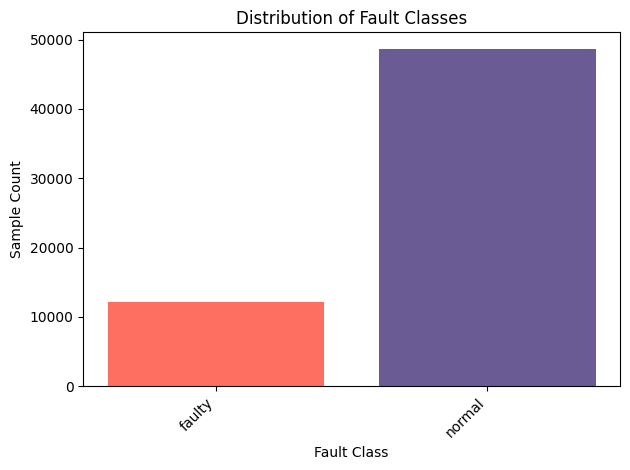

Chosen threshold (val): 0.22
[TEST] acc=0.6451 prec=0.9960 rec=0.5718 f1=0.7265
Train secs / CPU%: 848.85 / 77.2


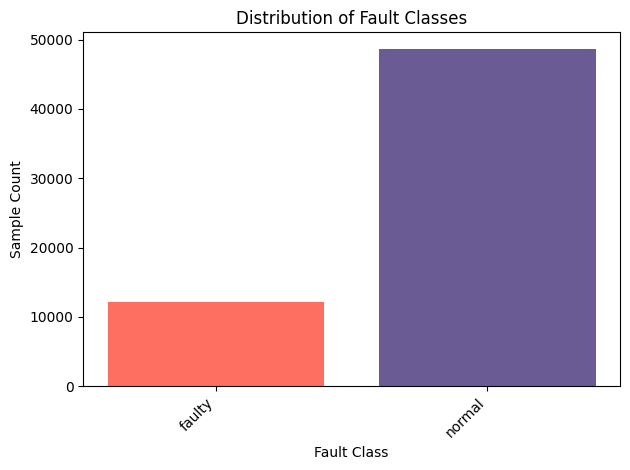

Chosen threshold (val): 0.82
[TEST] acc=0.4777 prec=0.8297 rec=0.3536 f1=0.4959
Train secs / CPU%: 781.92 / 77.7


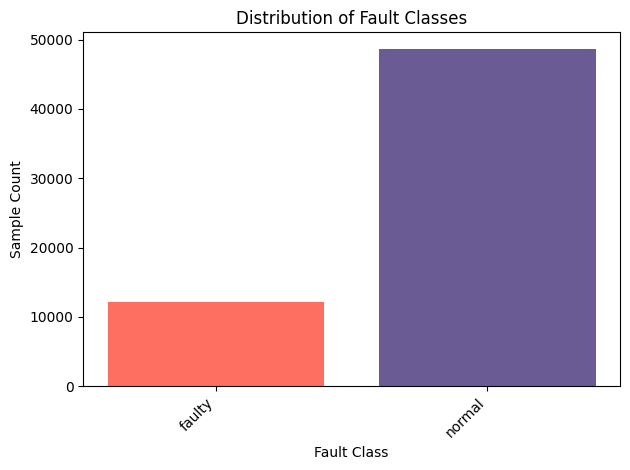

Chosen threshold (val): 0.05
[TEST] acc=0.9987 prec=1.0000 rec=0.9984 f1=0.9992
Train secs / CPU%: 483.93 / 78.5


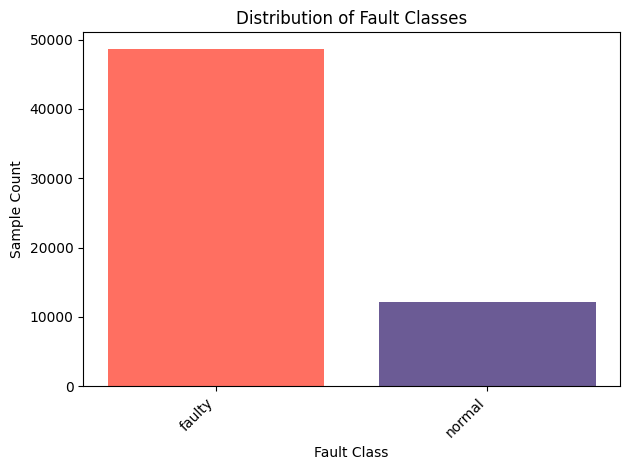

In [ ]:
fault_classes, _ = neural_network_detection(
    faulty_df=df_scenario_1,
    original_cols=['kelembaban_tanah_persen'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
print(fault_classes)

visualize_fault_classes(fault_classes)


fault_classes_df_scenario_2, _ = neural_network_detection(
    faulty_df=df_scenario_2,
    original_cols=['kelembaban_tanah_persen'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
print(fault_classes_df_scenario_2)
visualize_fault_classes(fault_classes_df_scenario_2)

fault_classes_df_scenario_3, _ = neural_network_detection(
    faulty_df=df_scenario_3,
    original_cols=['kelembaban_tanah_persen'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_3)

fault_classes_df_scenario_4, _ = neural_network_detection(
    faulty_df=df_scenario_4,
    original_cols=['kelembaban_tanah_persen'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_4)

fault_classes_df_scenario_5, _ = neural_network_detection(
    faulty_df=df_scenario_5,
    original_cols=['kelembaban_tanah_persen'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_5)

# Neural network 1 Layer -> Scenario 1 + 2 JST, Scenario 3 JSD

Chosen threshold (val): 0.05
[TEST] acc=0.9988 prec=0.9830 rec=1.0000 f1=0.9914
Train secs / CPU%: 407.75 / 76.7


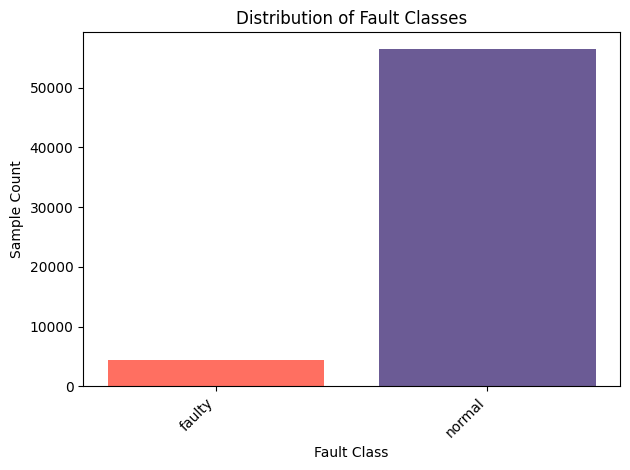

Chosen threshold (val): 0.05
[TEST] acc=0.0000 prec=0.0000 rec=0.0000 f1=0.0000
Train secs / CPU%: 548.78 / 76.5


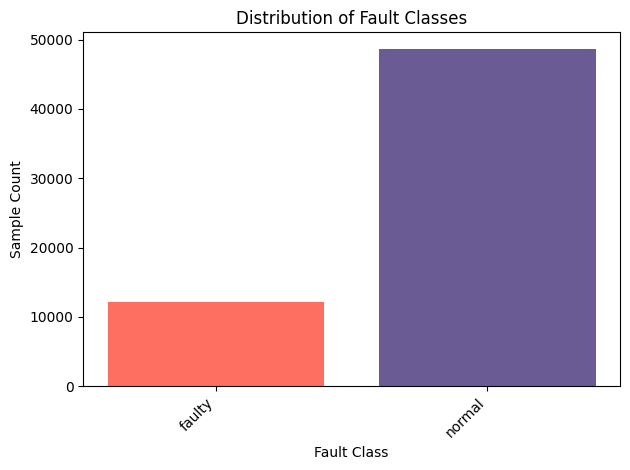

Chosen threshold (val): 0.32
[TEST] acc=0.6379 prec=0.9742 rec=0.5761 f1=0.7240
Train secs / CPU%: 575.82 / 76.4


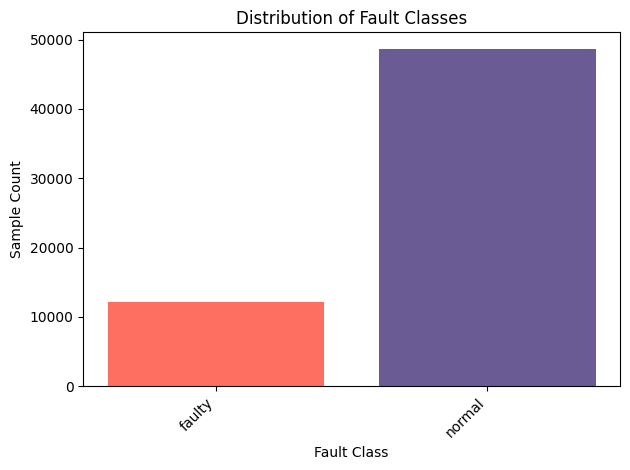

Chosen threshold (val): 0.51
[TEST] acc=0.4421 prec=0.7304 rec=0.3677 f1=0.4892
Train secs / CPU%: 514.30 / 75.7


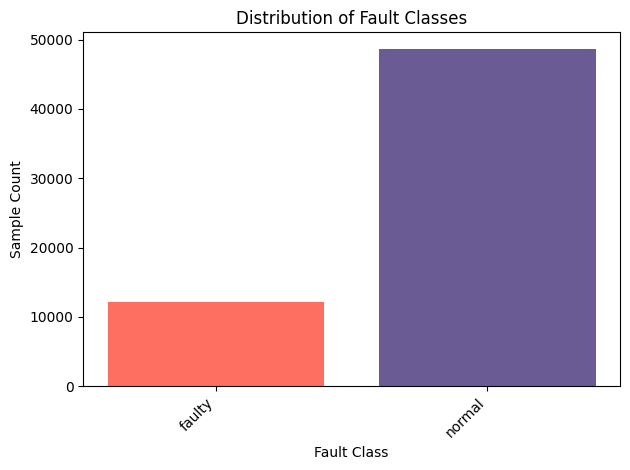

Chosen threshold (val): 0.05
[TEST] acc=0.9993 prec=0.9999 rec=0.9992 f1=0.9995
Train secs / CPU%: 378.94 / 77.4


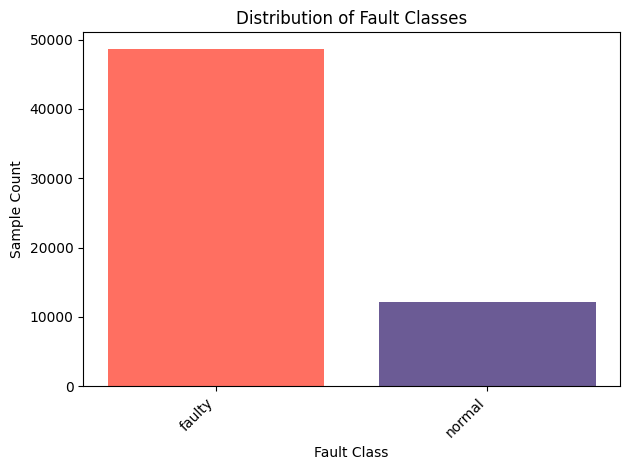

In [ ]:
fault_classes, _ = neural_network_detection(
    faulty_df=df_scenario_1,
    original_cols=['kelembaban_tanah_persen'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)

visualize_fault_classes(fault_classes)


fault_classes_df_scenario_2, _ = neural_network_detection(
    faulty_df=df_scenario_2,
    original_cols=['kelembaban_tanah_persen'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_2)

fault_classes_df_scenario_3, _ = neural_network_detection(
    faulty_df=df_scenario_3,
    original_cols=['kelembaban_tanah_persen'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_3)

fault_classes_df_scenario_4, _ = neural_network_detection(
    faulty_df=df_scenario_4,
    original_cols=['kelembaban_tanah_persen'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_4)

fault_classes_df_scenario_5, _ = neural_network_detection(
    faulty_df=df_scenario_5,
    original_cols=['kelembaban_tanah_persen'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_5)

# EDM Fuzzy

In [ ]:
from functools import partial
import numpy as np

#scales = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
#variatio
n_coeffs = [0.020, 0.021, 0.020, 0.019, 0.020, 0.021, 0.021, 0.021, 0.021, 0.022]

scales = [1]
variation_coeffs = [0.020]
weights = (1 / np.array(variation_coeffs))
weights /= weights.max()

entropy_feature_weights = {s: w for s, w in zip(scales, weights)}
edm_fuzzy_scaled = partial(edm_fuzzy, scales=scales)

for df_scenario in (df_scenario_1, df_scenario_2, df_scenario_3):
    fault_classes, results = neural_network_detection(
        faulty_df=df_scenario,
        original_cols=['kelembaban_tanah_persen'],
        entropy_fn=edm_fuzzy_scaled,
        entropy_name="edmfuzzy",
        use_two_layers=False,
        use_lm=True,
        entropy_feature_weights=entropy_feature_weights,
        hide_logging=False,
        h1_size=6,
        h2_size=3,
        max_nfev=60,
        scales=scales,
    )
    visualize_fault_classes(fault_classes)

TypeError: edm_fuzzy() got multiple values for argument 'scales'

# TERBARU

In [ ]:
import time, psutil, numpy as np, pandas as pd, inspect
BASE_SIGNALS = ["kelembaban1", "kelembaban2", "kelembaban3", "kelembaban4"]
BASE_SIGNAL = "kelembaban_tanah_persen"  # Keep for backward compatibility
POS_FRAC=0.20
TRAIN_FRAC=0.60
VAL_FRAC=0.20
TRAIN_SCENARIOS=[1]
TEST_SCENARIOS=[1]
TOP_CONFIGS=[{"use_two_layers":False,"h1":3,"h2":0,"max_nfev":40},{"use_two_layers":True,"h1":5,"h2":6,"max_nfev":40},{"use_two_layers":False,"h1":5,"h2":0,"max_nfev":40}]
SCENARIO_MAP={1:df_scenario_1,2:df_scenario_2,3:df_scenario_3,4:df_scenario_4,5:df_scenario_5}
def select_scales_from_cv(df_cv, method="EDM-Fuzzy", k=4):    try:        cva=(df_cv[df_cv["Method"]==method].groupby("Scale",as_index=False)["CV"].mean().dropna().sort_values("CV"))        picks=cva["Scale"].astype(int).tolist()[:k]        cv_map={int(s):float(cv) for s,cv in zip(cva["Scale"].astype(int),cva["CV"])}        picked=[cv_map[s] for s in picks]        w=(1.0/(np.array(picked)+1e-12)); w=(w/w.max()).astype(float)        weights={int(s):float(wi) for s,wi in zip(picks,w)}        return picks,weights,{s:cv_map[s] for s in picks}    except Exception:        picks=[5,7,9,11]; weights={s:1.0 for s in picks}; cv_map={s:float("nan") for s in picks}        return picks,weights,cv_mapedm_scales, edm_weights, edm_cvs = select_scales_from_cv(df_cv, "EDM-Fuzzy", k=4)jsd_scales=[5,7,9,11]; jsd_weights={s:1.0 for s in jsd_scales}; jsd_cvs={s:float("nan") for s in jsd_scales}
def synth_labels_train_q(concat_df, base_signal, train_len, pos_frac):
    thr=concat_df[base_signal].iloc[:train_len].quantile(1-pos_frac); y=(concat_df[base_signal]>=thr).astype(int)
    if y.nunique()<2:        for q in [0.75,0.70,0.65,0.60,0.55,0.50]:            thr=concat_df[base_signal].iloc[:train_len].quantile(q); y=(concat_df[base_signal]>=thr).astype(int)
    if y.nunique()>=2: break    return ydef prepare_dataset(train_scenarios, test_scenarios, base_signals=BASE_SIGNALS  # Updated to use 4 input nodes, pos_frac=POS_FRAC):
    tr=pd.concat([SCENARIO_MAP[s] 
for s in train_scenarios], ignore_index=True)
    te=pd.concat([SCENARIO_MAP[s] for s in test_scenarios], ignore_index=True)
    full=pd.concat([tr,te], ignore_index=True)
    if ("label_fault" in full.columns) and (pd.Series(full["label_fault"]).nunique()>=2):        full["label_active"]=full["label_fault"].astype(int); src="label_fault"    else:        full["label_active"]=synth_labels_train_q(full, base_signal, len(tr), pos_frac); src="heuristic"    return full,"label_active",src
def run_and_report(cfg, df_full, target_col, label_source, method_name, entropy_fn, scales, weights, cvs):
    proc=psutil.Process(); mem0=proc.memory_info().rss/1048576; cpu0=psutil.cpu_percent(interval=None); u0,s0=proc.cpu_times()[:2]; t0=time.time()    kwargs=dict(entropy_fn=entropy_fn, entropy_name=method_name.lower().replace("-",""), entropy_feature_weights=weights, scales=scales)
    if entropy_fn is not None else dict(entropy_fn=None, entropy_name=None, entropy_feature_weights=None, scales=None)    _,res=neural_network_detection(faulty_df=df_full, original_cols=[BASE_SIGNAL], target_col=target_col, base_signals=BASE_SIGNALS  
# Updated to use 4 input nodes, use_two_layers=cfg["use_two_layers"], h1_size=cfg["h1"], h2_size=(cfg["h2"] 
if cfg["use_two_layers"] else 0), max_nfev=cfg["max_nfev"], use_lm=True, hide_logging=True, **kwargs)    dur=time.time()-t0; cpu1=psutil.cpu_percent(interval=None); mem1=proc.memory_info().rss/1048576; u1,s1=proc.cpu_times()[:2]    avg_cpu=((u1-u0)+(s1-s0))/(max(dur,1e-6)*psutil.cpu_count())*100.0    te=res[res["split"]=="test"]; y=te["true_label"].to_numpy().astype(int); p=te["predicted_prob"].to_numpy()    t_star=res.attrs.get("t_star",0.5); yhat=(p>t_star).astype(int)    acc=float((y==yhat).mean()); tp=int(((y==1)&(yhat==1)).sum()); fp=int(((y==0)&(yhat==1)).sum()); fn=int(((y==1)&(yhat==0)).sum())    prec=tp/(tp+fp)
    if (tp+fp)>0 else 0.0; rec=tp/(tp+fn)
    if (tp+fn)>0 else 0.0; f1=2*prec*rec/(prec+rec)
    if (prec+rec)>0 else 0.0; avg_ent=float(te["entropy"].mean())
    if "entropy" in te else float("nan")    s_str="[]" if not scales else "["+", ".join(str(s) 
for s in scales)+"]"    cv_str="[]" if not scales else "["+", ".join("nan" if not np.isfinite(cvs.get(s,np.nan))
    else f"{cvs[s]:.6f}" for s in scales)+"]"    print(f"Label source:                   {label_source}")    print(f"Entropy method:                 {method_name}")    print(f"Selected scales:                {s_str}")    print(f"Scale CVs (matching order):     {cv_str}")    print(f"Scale weights:                  {weights if weights else {}}")    print(f"Memory before:                  {mem0:0.1f} MB")    print(f"Memory after:                   {mem1:0.1f} MB")    print(f"Avg Memory during training:     {((mem0+mem1)/2):0.1f} MB")    print(f"CPU usage before training:      {cpu0:0.1f} %")    print(f"CPU usage after training:       {cpu1:0.1f} %")    print(f"Training duration:              {dur:0.2f} s")    print(f"Avg CPU of this process:        {avg_cpu:0.1f} %")    print(f"Accuracy:                       {acc:0.4f}")    print(f"Precision:                      {prec:0.4f}")    print(f"Recall:                         {rec:0.4f}")    print(f"F1 Score:                       {f1:0.4f}")    print(f"Avg Entropy:                    {avg_ent:0.4f}")    print(f"(Config: two_layers={cfg['use_two_layers']}, h1={cfg['h1']}, h2={cfg['h2']}, max_nfev={cfg['max_nfev']})\n")
def _safe_minmax(a):
    a=np.asarray(a,dtype=float)
    if a.size==0: return a    mn=np.nanmin(a); mx=np.nanmax(a)
    return np.zeros_like(a)
    if (not np.isfinite(mn) or not np.isfinite(mx) or mx-mn<1e-12)
    else (a-mn)/(mx-mn)
def _call_entropy_fn(fn, x, scales=None, weights=None):
    sig=inspect.signature(fn); kwargs={}    if 'scales' in sig.parameters: kwargs['scales']=scales    if 'weights' in sig.parameters: kwargs['weights']=weights    elif 'scale_weights' in sig.parameters: kwargs['scale_weights']=weights    return fn(x,**kwargs)
    if kwargs else fn(x)
def edm_jsd_blend_entropy(x, scales):
    e_edm=np.asarray(_call_entropy_fn(edm_fuzzy,x,scales=scales,weights=None),dtype=float)    e_jsd=np.asarray(_call_entropy_fn(jsd_entropy_fn,x,scales=scales,weights=None),dtype=float)
    return 0.5*(_safe_minmax(e_edm)+_safe_minmax(e_jsd))combo_scales=sorted(set(edm_scales+jsd_scales))combo_weights={s:float(np.nanmean([edm_weights.get(s,1.0),jsd_weights.get(s,1.0)])) for s in combo_scales}combo_cvs={s:float(np.nanmean([edm_cvs.get(s,np.nan),jsd_cvs.get(s,np.nan)])) for s in combo_scales}
def compare_methods(train_scenarios=TRAIN_SCENARIOS, test_scenarios=TEST_SCENARIOS, configs=TOP_CONFIGS):    df_full,target_col,label_source=prepare_dataset(train_scenarios,test_scenarios,BASE_SIGNAL,POS_FRAC)    methods=[("No-Entropy",None,[],{},{}),             ("EDM-Fuzzy",edm_fuzzy,edm_scales,edm_weights,edm_cvs),             ("JSD",jsd_entropy_fn,jsd_scales,jsd_weights,jsd_cvs),             ("EDM+JSD",edm_jsd_blend_entropy,combo_scales,combo_weights,combo_cvs)]    for cfg in configs:        for name,fn,scales,weights,cvs in methods:            run_and_report(cfg,df_full,target_col,label_source,name,fn,scales,weights,cvs)compare_methods()

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time, psutil, os, platform
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score



# --- Scenario map with different seeds ---
def build_scenarios(df, base):
    scenarios={}
    y1,m1=simulate_spike_fault(df[base].to_numpy(),seed=1)
    df1=df.copy(); df1[base+"_spike"]=y1; df1["label_fault"]=m1.astype(int)
    scenarios[1]=df1

    y2a,m2a=simulate_drift_fault(df[base].to_numpy(),seed=2)
    y2b,m2b=simulate_hardware_fault(df[base].to_numpy(),seed=3)
    df2=df.copy(); df2[base+"_drift"]=y2a; df2[base+"_hw"]=y2b
    df2["label_fault"]=(m2a|m2b).astype(int)
    scenarios[2]=df2

    y3,m3=simulate_multiple_faults(df[base].to_numpy(),
        [(simulate_spike_fault,{}),(simulate_bias_fault,{})],seed=4)
    df3=df.copy(); df3[base+"_mix"]=y3; df3["label_fault"]=m3.astype(int)
    scenarios[3]=df3

    y4,m4=simulate_multiple_faults(df[base].to_numpy(),
        [(simulate_drift_fault,{}),(simulate_bias_fault,{}),(simulate_hardware_fault,{})],seed=5)
    df4=df.copy(); df4[base+"_combo"]=y4; df4["label_fault"]=m4.astype(int)
    scenarios[4]=df4

    y5,m5=simulate_multiple_faults(df[base].to_numpy(),
        [(simulate_spike_fault,{}),(simulate_drift_fault,{}),
         (simulate_bias_fault,{}),(simulate_hardware_fault,{})],seed=6)
    df5=df.copy(); df5[base+"_all"]=y5; df5["label_fault"]=m5.astype(int)
    scenarios[5]=df5

    return scenarios

SCENARIO_MAP=build_scenarios(df,base)

def sigmoid(z):
    out=np.empty_like(z,dtype=float); pos=z>=0
    out[pos]=1/(1+np.exp(-z[pos])); ez=np.exp(z[~pos]); out[~pos]=ez/(1+ez)
    return out

def neural_net_predict(params,X,d,h1,h2,two_layers):
    i=0
W1=params[i:i+d*h1].reshape(d,h1); i+=d*h1; b1=params[i:i+h1].reshape(1,h1); i+=h1
    if two_layers:
        W2=params[i:i+h1*h2].reshape(h1,h2); i+=h1*h2; b2=params[i:i+h2].reshape(1,h2); i+=h2
        W3=params[i:i+h2].reshape(h2,1); i+=h2; a1=np.tanh(X@W1+b1); a2=np.tanh(a1@W2+b2)
    else:
        W3=params[i:i+h1].reshape(h1,1); i+=h1; a2=np.tanh(X@W1+b1)
    b3=np.array([[params[i]]]); return sigmoid(a2@W3+b3).ravel()

def residuals(params,X,y,d,h1,h2,two_layers,l2=1e-3):
    p=neural_net_predict(params,X,d,h1,h2,two_layers); return np.concatenate([p-y, np.sqrt(l2)*params])

def make_features(df, base_col, label_col):
    x=df.copy(); x[base_col+"_diff"]=x[base_col].diff()
    feats=[c for c in x.select_dtypes(include=[np.number]).columns if c!=label_col]
    x[feats]=x[feats].fillna(x[feats].median())
    mask=(~x[feats].isna().any(axis=1)) & x[label_col].notna()
    return x.loc[mask,feats].to_numpy(), x.loc[mask,label_col].astype(int).to_numpy().ravel(), feats

def time_block_split_balanced(X,y,tr_frac=0.6,va_frac=0.2,gap=256,search_window=8192):
    n=len(X); i1=int(n*tr_frac); i2=int(n*(tr_frac+va_frac))
    def has_both(a): return np.unique(a).size>1
    lo=max(0,i1-search_window); hi=min(n-2, i1+search_window)
    best=None
    for j in range(lo,hi+1):
    i1g=min(n, j+min(gap,max(0,i2-j-1))); i2g=min(n, i2+gap)
        y_tr=y[:j]; y_va=y[i1g:i2]; y_te=y[i2g:]
        if len(y_tr)==0 or len(y_va)==0 or len(y_te)==0: continue
        if has_both(y_tr) and has_both(y_va) and has_both(y_te):
    best=(j,i1g,i2,i2g); break
    if best is None:
        i1g=min(n,i1+min(gap,max(0,i2-i1-1))); i2g=min(n,i2+gap)
    return X[:i1],X[i1g:i2],X[i2g:],y[:i1],y[i1g:i2],y[i2g:]
    j,i1g,i2,i2g=best
    return X[:j],X[i1g:i2],X[i2g:],y[:j],y[i1g:i2],y[i2g:]

def entropy_avg(probs,eps=1e-12):
    p=np.clip(probs,eps,1-eps); return np.mean(-(p*np.log(p)+(1-p)*np.log(1-p)))

def run_experiment(scenario_map, base, train_scenarios, test_scenarios, configs, tr_frac=0.6, va_frac=0.2, gap=256, l2=1e-3, seed=42,
                   label_source="synthetic faults", method_name="FuzzyEn-JST", selected_scales=None, scale_cvs=None, weights=None):
    tr=pd.concat([scenario_map[s] for s in train_scenarios],ignore_index=True)
    te=pd.concat([scenario_map[s] for s in test_scenarios],ignore_index=True)
    df_all=pd.concat([tr,te],ignore_index=True)
    X,y,feats=make_features(df_all, base, "label_fault")
    X_tr,X_va,X_te,y_tr,y_va,y_te=time_block_split_balanced(X,y,tr_frac,va_frac,gap)
    scaler=StandardScaler().fit(X_tr); X_tr=scaler.transform(X_tr); X_va=scaler.transform(X_va); X_te=scaler.transform(X_te)

    s_str=", ".join(map(str, selected_scales or [])) or "-"
    cv_str=", ".join(f"{v:0.3f}" for v in (scale_cvs or [])) or "-"
    weights = weights or {}
    process=psutil.Process(os.getpid())

    rows=[]

    # === Baseline: Logistic Regression ===
    t0=time.perf_counter(); mem0=process.memory_info().rss/1e6; cpu0=psutil.cpu_percent(interval=0.1)
    clf=LogisticRegression(max_iter=1000, n_jobs=None); clf.fit(X_tr,y_tr)
    p_va=clf.predict_proba(X_va)[:,1]; ts=np.linspace(0.05,0.95,91); fbest=-1; tstar=0.5
    for t in ts:
        yhat=(p_va>t).astype(int); f=f1_score(y_va,yhat,zero_division=0)
    if f>fbest: fbest=f; tstar=t
    p_te=clf.predict_proba(X_te)[:,1]; yhat=(p_te>tstar).astype(int)
    acc=(y_te==yhat).mean(); prec=precision_score(y_te,yhat,zero_division=0); rec=recall_score(y_te,yhat,zero_division=0); f1=f1_score(y_te,yhat,zero_division=0)
    auroc=roc_auc_score(y_te,p_te); auprc=average_precision_score(y_te,p_te); bacc=balanced_accuracy_score(y_te,yhat)
    avg_ent=entropy_avg(p_te); cpu1=psutil.cpu_percent(interval=0.1); mem1=process.memory_info().rss/1e6; dur=time.perf_counter()-t0
    avg_cpu=process.cpu_percent(interval=0.2)
    print(f"Label source:                   {label_source}")
    print(f"Entropy method:                 {method_name}")
    print(f"Selected scales:                {s_str}")
    print(f"Scale CVs (matching order):     {cv_str}")
    print(f"Scale weights:                  {weights if weights else {}}")
    print(f"Memory before:                  {mem0:0.1f} MB")
    print(f"Memory after:                   {mem1:0.1f} MB")
    print(f"Avg Memory during training:     {((mem0+mem1)/2):0.1f} MB")
    print(f"CPU usage before training:      {cpu0:0.1f} %")
    print(f"CPU usage after training:       {cpu1:0.1f} %")
    print(f"Training duration:              {dur:0.2f} s")
    print(f"Avg CPU of this process:        {avg_cpu:0.1f} %")
    print(f"Accuracy:                       {acc:0.4f}")
    print(f"Precision:                      {prec:0.4f}")
    print(f"Recall:                         {rec:0.4f}")
    print(f"F1 Score:                       {f1:0.4f}")
    print(f"Avg Entropy:                    {avg_ent:0.4f}")
    print(f"(Config: two_layers=False, h1=0, h2=0, max_nfev=0)")
    print(f"AUROC:                          {auroc:0.4f}")
    print(f"AUPRC:                          {auprc:0.4f}")
    print(f"Balanced Acc:                   {bacc:0.4f}\n")
    rows.append({
        "model":"LogReg","config":{"use_two_layers":False,"h1":0,"h2":0,"max_nfev":0},
        "acc":acc,"prec":prec,"rec":rec,"f1":f1,"auroc":auroc,"auprc":auprc,"bacc":bacc,"avg_entropy":avg_ent,
        "train_time_s":dur,"cpu_before_pct":cpu0,"cpu_after_pct":cpu1,"avg_cpu_pct":avg_cpu,
        "mem_before_mb":mem0,"mem_after_mb":mem1,"avg_mem_mb":(mem0+mem1)/2
    })

    # === Neural net configs ===
    for cfg in configs:
        rng=np.random.default_rng(seed); d=X_tr.shape[1]
        psize=d*cfg["h1"]+cfg["h1"]+(cfg["h1"]*cfg["h2"]+cfg["h2"] if cfg["use_two_layers"] else 0)+(cfg["h2"] if cfg["use_two_layers"] else cfg["h1"])+1
        p0=rng.standard_normal(psize)
        t0=time.perf_counter(); mem0=process.memory_info().rss/1e6; cpu0=psutil.cpu_percent(interval=0.1)
        res=least_squares(residuals,p0,args=(X_tr,y_tr,d,cfg["h1"],cfg["h2"],cfg["use_two_layers"],l2),max_nfev=cfg["max_nfev"],method="lm")
        w=res.x
        p_va=neural_net_predict(w,X_va,d,cfg["h1"],cfg["h2"],cfg["use_two_layers"])
        ts=np.linspace(0.05,0.95,91); fbest=-1; tstar=0.5
        for t in ts:
            yhat=(p_va>t).astype(int); f=f1_score(y_va,yhat,zero_division=0)
    if f>fbest: fbest=f; tstar=t
        p_te=neural_net_predict(w,X_te,d,cfg["h1"],cfg["h2"],cfg["use_two_layers"])
        yhat=(p_te>tstar).astype(int)
        acc=(y_te==yhat).mean(); prec=precision_score(y_te,yhat,zero_division=0); rec=recall_score(y_te,yhat,zero_division=0); f1=f1_score(y_te,yhat,zero_division=0)
        auroc=roc_auc_score(y_te,p_te); auprc=average_precision_score(y_te,p_te); bacc=balanced_accuracy_score(y_te,yhat)
        avg_ent=entropy_avg(p_te); cpu1=psutil.cpu_percent(interval=0.1); mem1=process.memory_info().rss/1e6; dur=time.perf_counter()-t0
        avg_cpu=process.cpu_percent(interval=0.2)
        print(f"Label source:                   {label_source}")
        print(f"Entropy method:                 {method_name}")
        print(f"Selected scales:                {s_str}")
        print(f"Scale CVs (matching order):     {cv_str}")
        print(f"Scale weights:                  {weights if weights else {}}")
        print(f"Memory before:                  {mem0:0.1f} MB")
        print(f"Memory after:                   {mem1:0.1f} MB")
        print(f"Avg Memory during training:     {((mem0+mem1)/2):0.1f} MB")
        print(f"CPU usage before training:      {cpu0:0.1f} %")
        print(f"CPU usage after training:       {cpu1:0.1f} %")
        print(f"Training duration:              {dur:0.2f} s")
        print(f"Avg CPU of this process:        {avg_cpu:0.1f} %")
        print(f"Accuracy:                       {acc:0.4f}")
        print(f"Precision:                      {prec:0.4f}")
        print(f"Recall:                         {rec:0.4f}")
        print(f"F1 Score:                       {f1:0.4f}")
        print(f"Avg Entropy:                    {avg_ent:0.4f}")
        print(f"(Config: two_layers={cfg['use_two_layers']}, h1={cfg['h1']}, h2={cfg['h2']}, max_nfev={cfg['max_nfev']})")
        print(f"AUROC:                          {auroc:0.4f}")
        print(f"AUPRC:                          {auprc:0.4f}")
        print(f"Balanced Acc:                   {bacc:0.4f}\n")
        rows.append({
            "model":"NN","config":cfg,"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auroc":auroc,"auprc":auprc,"bacc":bacc,"avg_entropy":avg_ent,
            "train_time_s":dur,"cpu_before_pct":cpu0,"cpu_after_pct":cpu1,"avg_cpu_pct":avg_cpu,
            "mem_before_mb":mem0,"mem_after_mb":mem1,"avg_mem_mb":(mem0+mem1)/2
        })

    df=pd.DataFrame(rows)

    # Simple composite "cost" (lower is better): normalized train_time + avg_mem + avg_cpu
    for col in ["train_time_s","avg_mem_mb","avg_cpu_pct"]:
        m=df[col].min(); M=df[col].max(); df[col+"_norm"]=0 if M==m else (df[col]-m)/(M-m)
    df["cost_score"]=df["train_time_s_norm"]+df["avg_mem_mb_norm"]+df["avg_cpu_pct_norm"]

    # Ranks (1 = best, largest accuracy; 1 = best, smallest cost)
    df["rank_acc"]=df["acc"].rank(ascending=False,method="min").astype(int)
    df["rank_cost"]=df["cost_score"].rank(ascending=True,method="min").astype(int)
    return df, {"train":dict(zip(*np.unique(y_tr,return_counts=True))),
                "val":dict(zip(*np.unique(y_va,return_counts=True))),
                "test":dict(zip(*np.unique(y_te,return_counts=True)))}


# Example:
# scenario_map=build_scenarios(df, base)
# 
TOP_CONFIGS=[{"use_two_layers":False,"h1":3,"h2":0,"max_nfev":40},{"use_two_layers":True,"h1":5,"h2":4,"max_nfev":40}]
results, diag = run_experiment(SCENARIO_MAP, base, train_scenarios=[1], test_scenarios=[2,3,4,5], configs=TOP_CONFIGS,
                               label_source="synthetic faults", method_name="SampleEntropy",
                               selected_scales=[2,3,4], scale_cvs=[0.12,0.15,0.09], weights={"2":0.4,"3":0.4,"4":0.2})

print("\n=== Worst → Best by Accuracy ===")
print(results.sort_values("acc", ascending=True)[["model","config","acc","rank_acc"]])

print("\n=== Worst → Best by Computation Cost ===")
print(results.sort_values("cost_score", ascending=True)[["model","config","train_time_s","avg_mem_mb","avg_cpu_pct","cost_score","rank_cost"]])